In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
%matplotlib inline
import os
from tensorflow.contrib.timeseries.python.timeseries import NumpyReader

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing   
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM



Using TensorFlow backend.


In [2]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    dataset=dataset.tolist()
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def split_dataset(data):
	predict_index=1      # the test data need to be two years!!!   
	# split into standard weeks
	train, test = data[0:len(data)-12*predict_index], data[len(data)-12*predict_index::]
	# restructure into windows of montyly data
	train = np.array(np.split(train, len(train)/12))
	test = np.array(np.split(test, len(test)/12))
	return train, test

In [3]:
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [4]:
def build_model(train_x,train_y,n_input,n_out,  n_steps, n_length):
	# define parameters
	verbose, epochs, batch_size = 2,200,32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_x = train_x.reshape((train_x.shape[0], n_steps,1, n_length, n_features))
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1],1))
	# define model

	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='linear')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# fit network
	return model


In [5]:
# make a forecast
def forecast(model, history, n_input, n_steps, n_length):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	print (data.shape)
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, n_steps,1,n_length, 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input,n_steps, n_length):
	# fit model
#	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	print (len(history))
	print (history[0])
	#print (len(test))
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input,n_steps, n_length)
		print ("the prediction values are:{0}".format(yhat_sequence))
		print ("the real values are:{0}".format(test[i, :, 0]))
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions) 
	return score, scores,predictions

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		print (actual.shape[1])
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		print (actual[:, i])
		print (predicted[:, i])
		print (mse)
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
    
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs

In [6]:
real_in_one=[]
prediction_in_one=[]
train_prediciton_in_one=[]
dataset_in_one=[]
signals=[]
all_signals=[]
file_name="ONI"
with open("{0}.txt".format(file_name)) as file:
    for lines in  file:
        every_signal=[]
        line=lines.split(",")
        for element in line:
            every_signal.append(float(element))
        all_signals.append(every_signal)
        signals.append(every_signal)

data={}
pd_date=pd.date_range('1/1/1950','12/1/2018',freq='MS')
data["date"]=pd_date

for i in range(len(signals)):
    index="f"+str(i)
    data[index]=signals[i]


df=pd.DataFrame(data)
df.to_csv("{0}_data.txt".format(file_name))

print (df.shape)

if(os.path.exists('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')

(828, 10)


0     -0.025547
1      0.092241
2      0.091614
3     -0.029861
4     -0.081061
5     -0.081246
6      0.075370
7     -0.018363
8     -0.065202
9      0.064017
10     0.035250
11    -0.054299
12    -0.080261
13     0.032733
14     0.039559
15     0.112890
16     0.014132
17    -0.040457
18    -0.143370
19    -0.080158
20    -0.046180
21     0.160100
22     0.036908
23    -0.030857
24    -0.161610
25    -0.074868
26     0.005449
27     0.152760
28     0.140540
29    -0.030355
         ...   
738    0.255480
739    0.081523
740   -0.079644
741   -0.245120
742   -0.228700
743   -0.134050
744    0.025670
745    0.131620
746    0.071521
747   -0.037868
748   -0.069171
749    0.015659
750    0.046654
751   -0.041721
752   -0.004281
753    0.038246
754    0.042989
755    0.042706
756   -0.045968
757    0.025651
758    0.045020
759    0.014518
760   -0.043308
761    0.044599
762   -0.025464
763   -0.054690
764    0.003660
765    0.079245
766    0.087195
767    0.007241
Name: f0, Length: 768, d

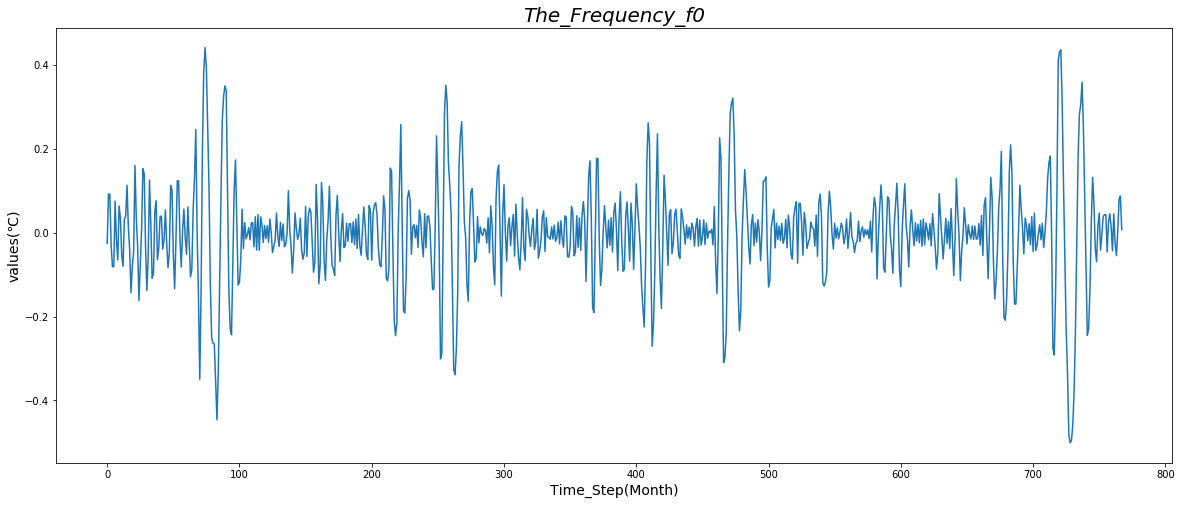

[[[-2.5547e-02]
  [ 9.2241e-02]
  [ 9.1614e-02]
  [-2.9861e-02]
  [-8.1061e-02]
  [-8.1246e-02]
  [ 7.5370e-02]
  [-1.8363e-02]
  [-6.5202e-02]
  [ 6.4017e-02]
  [ 3.5250e-02]
  [-5.4299e-02]]

 [[-8.0261e-02]
  [ 3.2733e-02]
  [ 3.9559e-02]
  [ 1.1289e-01]
  [ 1.4132e-02]
  [-4.0457e-02]
  [-1.4337e-01]
  [-8.0158e-02]
  [-4.6180e-02]
  [ 1.6010e-01]
  [ 3.6908e-02]
  [-3.0857e-02]]

 [[-1.6161e-01]
  [-7.4868e-02]
  [ 5.4492e-03]
  [ 1.5276e-01]
  [ 1.4054e-01]
  [-3.0355e-02]
  [-1.3808e-01]
  [-5.8738e-02]
  [ 1.2519e-01]
  [ 1.9747e-02]
  [-1.0855e-01]
  [-9.7296e-02]]

 [[ 4.9602e-02]
  [ 7.6171e-02]
  [-6.4388e-02]
  [-3.7326e-02]
  [ 3.8834e-02]
  [ 3.9240e-02]
  [-3.9069e-02]
  [-1.8257e-02]
  [ 5.4259e-02]
  [-2.5882e-02]
  [-8.3007e-02]
  [-4.7521e-02]]

 [[ 1.1258e-01]
  [ 1.0203e-01]
  [-5.0122e-02]
  [-1.3377e-01]
  [-1.6454e-02]
  [ 1.2364e-01]
  [ 1.2345e-01]
  [-1.0158e-02]
  [-8.2005e-02]
  [ 4.5278e-03]
  [ 5.6274e-02]
  [-1.0434e-02]]

 [[-5.1485e-02]
  [ 6.1355e-02

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 9s - loss: 0.0140
Epoch 2/200
 - 2s - loss: 0.0140
Epoch 3/200
 - 2s - loss: 0.0139
Epoch 4/200
 - 2s - loss: 0.0138
Epoch 5/200
 - 2s - loss: 0.0136
Epoch 6/200
 - 2s - loss: 0.0133
Epoch 7/200
 - 3s - loss: 0.0126
Epoch 8/200
 - 2s - loss: 0.0122
Epoch 9/200
 - 2s - loss: 0.0120
Epoch 10/200
 - 2s - loss: 0.0115
Epoch 11/200
 - 2s - loss: 0.0116
Epoch 12/200
 - 2s - loss: 0.0112
Epoch 13/200
 - 2s - loss: 0.0109
Epoch 14/200
 - 2s - loss: 0.0106
Epoch 15/200
 - 2s - loss: 0.0104
Epoch 16/200
 - 2s - loss: 0.0102
Epoch 17/200
 - 2s - loss: 0.0098
Epoch 18/200
 - 2s - loss: 0.0100
Epoch 19/200
 - 2s - loss: 0.0099
Epoch 20/200
 - 2s - loss: 0.0100
Epoch 21/200
 - 2s - loss: 0.0097
Epoch 22/200
 - 2s - loss: 0.0093
Epoch 23/200
 - 2s - loss: 0.0094
Epoch 24/200
 - 2s - loss: 0.0093
Epoch 25/200
 - 2s - loss: 0.0094
Epoch 26/200
 - 2s - loss: 0.0092
Epoch 27/200
 - 2s - loss: 0.0091
Epoch 28/200
 - 1s - loss: 0.0087
Epoch 29/

(61, 12)


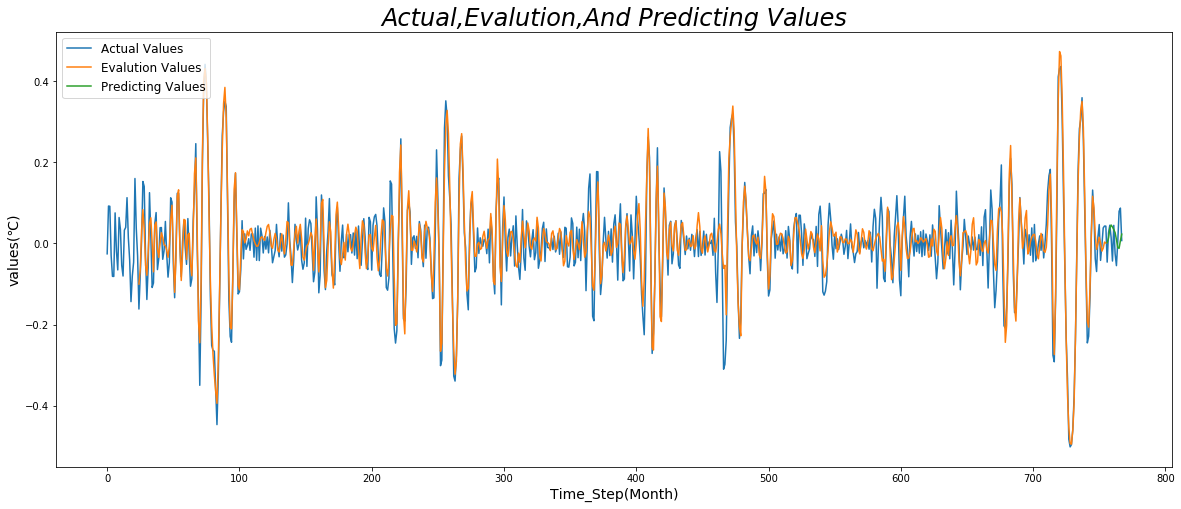

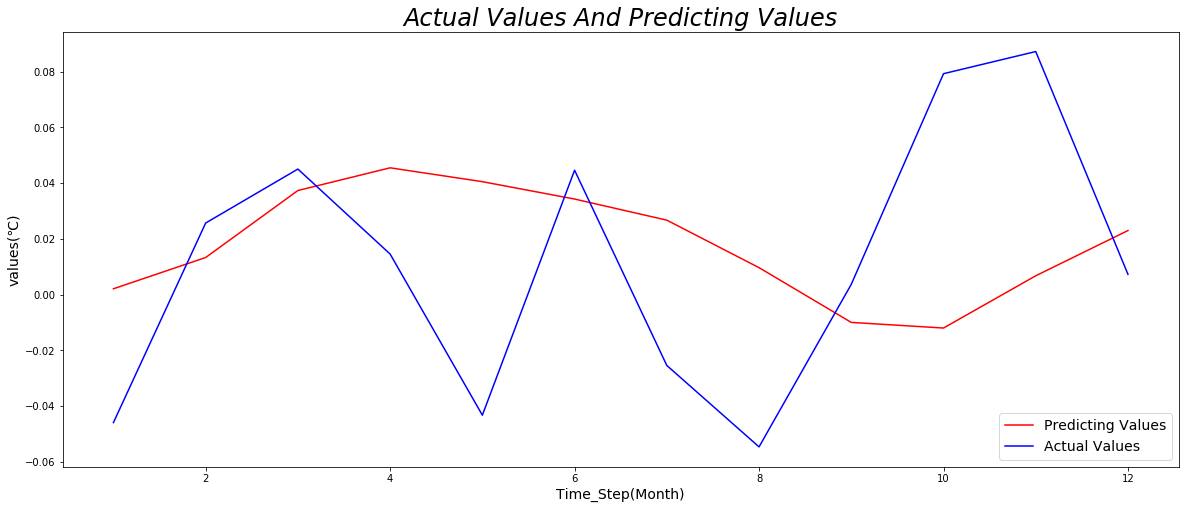

0     -0.294540
1     -0.206260
2     -0.114940
3     -0.018285
4      0.092434
5      0.236340
6      0.407510
7      0.512940
8      0.455400
9      0.206520
10    -0.097637
11    -0.351990
12    -0.478850
13    -0.451500
14    -0.319580
15    -0.149650
16     0.002985
17     0.128160
18     0.224470
19     0.283560
20     0.306910
21     0.296920
22     0.250800
23     0.176900
24     0.086898
25    -0.006406
26    -0.085830
27    -0.131520
28    -0.123820
29    -0.071080
         ...   
738    0.431720
739    0.329120
740    0.190310
741    0.038030
742   -0.108260
743   -0.239260
744   -0.336230
745   -0.374840
746   -0.337770
747   -0.237250
748   -0.096246
749    0.051585
750    0.180610
751    0.260780
752    0.248830
753    0.157580
754    0.019498
755   -0.108560
756   -0.153610
757   -0.072965
758    0.044407
759    0.096376
760    0.061819
761   -0.026199
762   -0.056685
763   -0.023493
764    0.022220
765    0.044032
766    0.021371
767   -0.025670
Name: f1, Length: 768, d

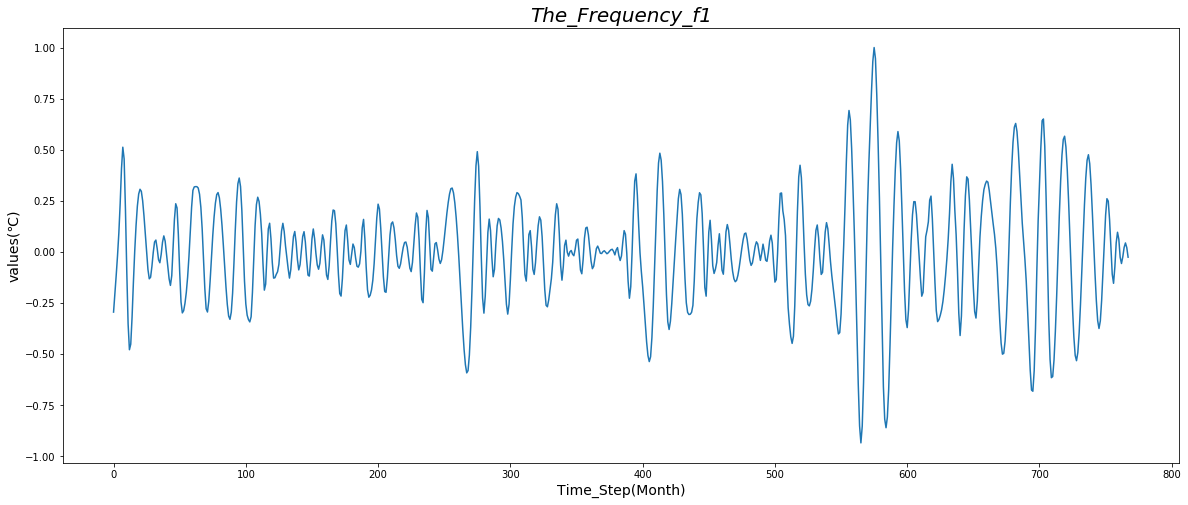

[[[-2.9454e-01]
  [-2.0626e-01]
  [-1.1494e-01]
  [-1.8285e-02]
  [ 9.2434e-02]
  [ 2.3634e-01]
  [ 4.0751e-01]
  [ 5.1294e-01]
  [ 4.5540e-01]
  [ 2.0652e-01]
  [-9.7637e-02]
  [-3.5199e-01]]

 [[-4.7885e-01]
  [-4.5150e-01]
  [-3.1958e-01]
  [-1.4965e-01]
  [ 2.9850e-03]
  [ 1.2816e-01]
  [ 2.2447e-01]
  [ 2.8356e-01]
  [ 3.0691e-01]
  [ 2.9692e-01]
  [ 2.5080e-01]
  [ 1.7690e-01]]

 [[ 8.6898e-02]
  [-6.4059e-03]
  [-8.5830e-02]
  [-1.3152e-01]
  [-1.2382e-01]
  [-7.1080e-02]
  [-3.0445e-03]
  [ 4.8778e-02]
  [ 5.8154e-02]
  [ 1.5810e-02]
  [-3.7963e-02]
  [-5.2927e-02]]

 [[-1.2426e-02]
  [ 4.7069e-02]
  [ 7.8590e-02]
  [ 5.3272e-02]
  [-5.8918e-03]
  [-6.9886e-02]
  [-1.3140e-01]
  [-1.6388e-01]
  [-1.1630e-01]
  [ 1.6081e-02]
  [ 1.5718e-01]
  [ 2.3609e-01]]

 [[ 2.1549e-01]
  [ 8.3197e-02]
  [-9.7596e-02]
  [-2.4477e-01]
  [-2.9853e-01]
  [-2.8754e-01]
  [-2.5153e-01]
  [-1.9811e-01]
  [-1.2294e-01]
  [-2.2837e-02]
  [ 9.6141e-02]
  [ 2.1869e-01]]

 [[ 3.0174e-01]
  [ 3.1849e-01

Epoch 1/200
 - 6s - loss: 0.0672
Epoch 2/200
 - 2s - loss: 0.0601
Epoch 3/200
 - 2s - loss: 0.0523
Epoch 4/200
 - 2s - loss: 0.0448
Epoch 5/200
 - 2s - loss: 0.0444
Epoch 6/200
 - 2s - loss: 0.0397
Epoch 7/200
 - 2s - loss: 0.0365
Epoch 8/200
 - 2s - loss: 0.0358
Epoch 9/200
 - 2s - loss: 0.0349
Epoch 10/200
 - 2s - loss: 0.0306
Epoch 11/200
 - 2s - loss: 0.0307
Epoch 12/200
 - 2s - loss: 0.0334
Epoch 13/200
 - 2s - loss: 0.0320
Epoch 14/200
 - 2s - loss: 0.0285
Epoch 15/200
 - 2s - loss: 0.0292
Epoch 16/200
 - 2s - loss: 0.0287
Epoch 17/200
 - 2s - loss: 0.0273
Epoch 18/200
 - 2s - loss: 0.0267
Epoch 19/200
 - 2s - loss: 0.0274
Epoch 20/200
 - 2s - loss: 0.0281
Epoch 21/200
 - 2s - loss: 0.0274
Epoch 22/200
 - 2s - loss: 0.0259
Epoch 23/200
 - 2s - loss: 0.0264
Epoch 24/200
 - 2s - loss: 0.0257
Epoch 25/200
 - 2s - loss: 0.0242
Epoch 26/200
 - 2s - loss: 0.0236
Epoch 27/200
 - 2s - loss: 0.0236
Epoch 28/200
 - 2s - loss: 0.0234
Epoch 29/200
 - 2s - loss: 0.0266
Epoch 30/200
 - 2s - lo

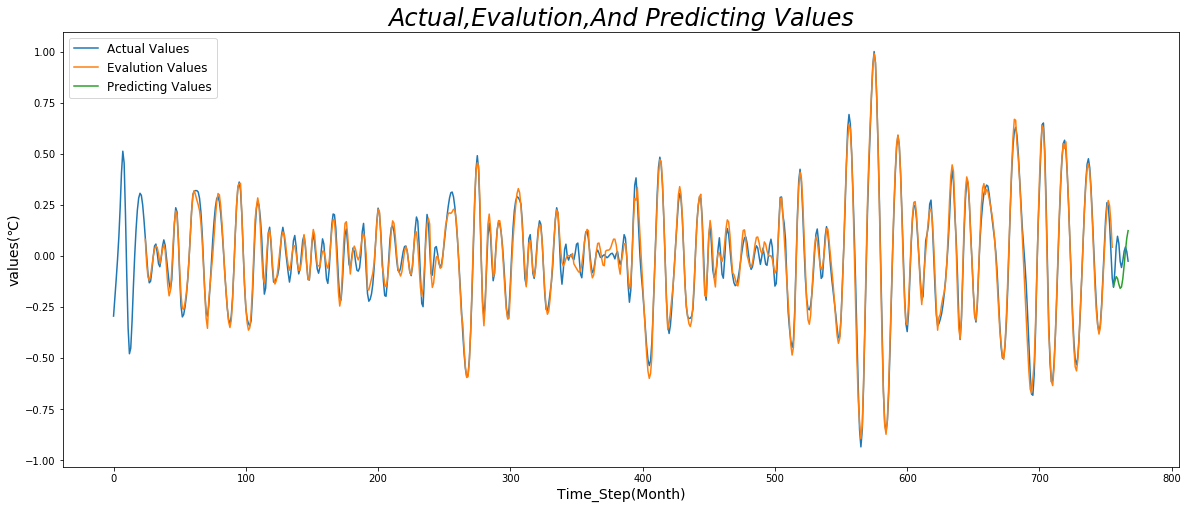

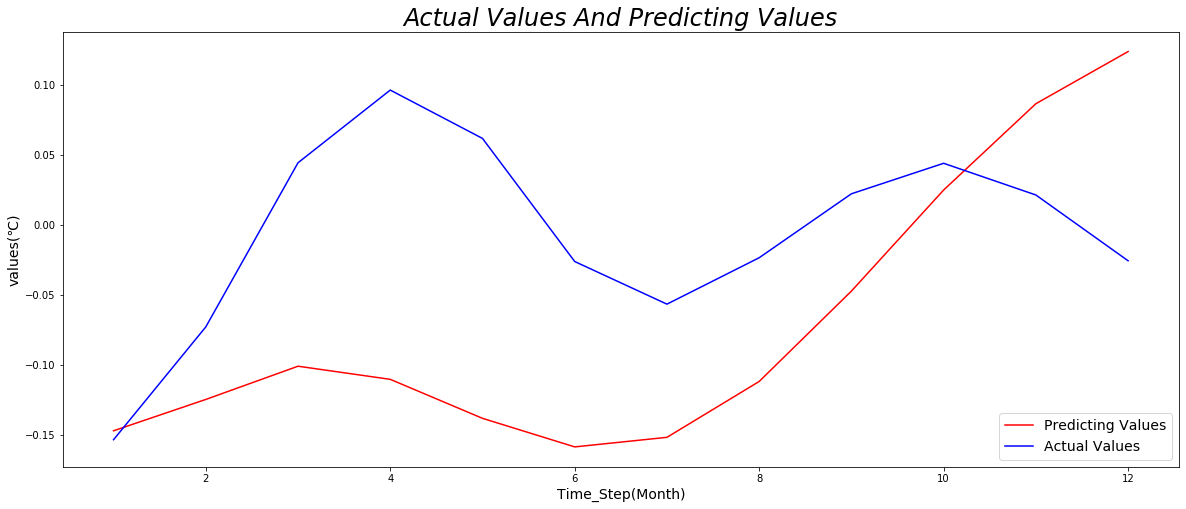

0     -0.438890
1     -0.456720
2     -0.466010
3     -0.466450
4     -0.457420
5     -0.438230
6     -0.408210
7     -0.366670
8     -0.313070
9     -0.247670
10    -0.171950
11    -0.087650
12     0.003699
13     0.100570
14     0.198250
15     0.291170
16     0.373790
17     0.440530
18     0.485840
19     0.504150
20     0.489910
21     0.439690
22     0.358500
23     0.253460
24     0.131690
25     0.000284
26    -0.133640
27    -0.262960
28    -0.380460
29    -0.478240
         ...   
738   -0.561790
739   -0.518520
740   -0.457210
741   -0.382230
742   -0.297980
743   -0.208850
744   -0.119160
745   -0.033139
746    0.045401
747    0.113200
748    0.167120
749    0.204010
750    0.220720
751    0.214080
752    0.182920
753    0.134410
754    0.077831
755    0.022456
756   -0.022442
757   -0.049362
758   -0.057898
759   -0.049598
760   -0.028074
761   -0.002634
762    0.015288
763    0.017141
764    0.006707
765   -0.008962
766   -0.023666
767   -0.036315
Name: f2, Length: 768, d

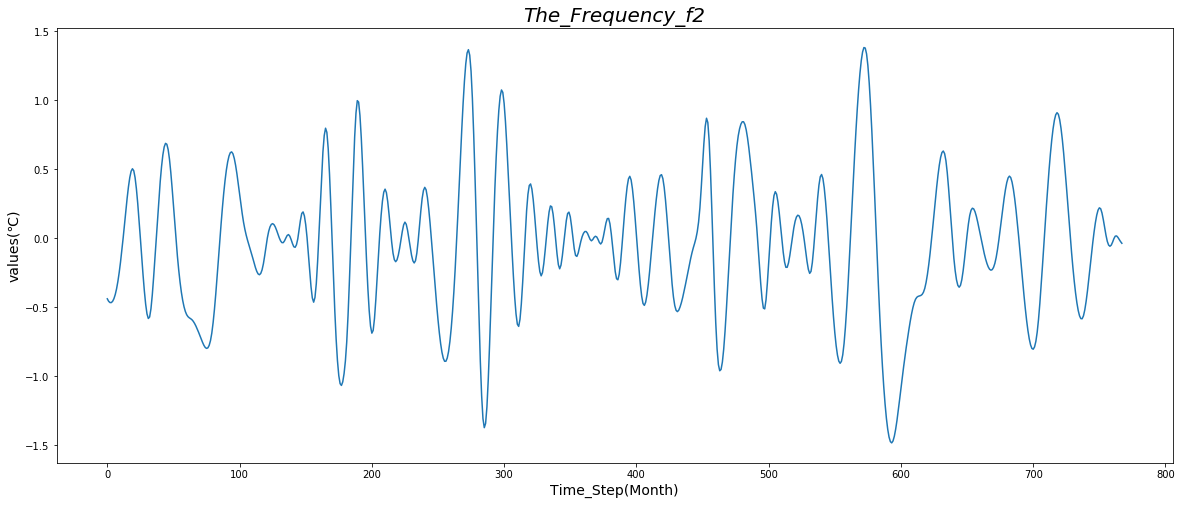

[[[-4.3889e-01]
  [-4.5672e-01]
  [-4.6601e-01]
  [-4.6645e-01]
  [-4.5742e-01]
  [-4.3823e-01]
  [-4.0821e-01]
  [-3.6667e-01]
  [-3.1307e-01]
  [-2.4767e-01]
  [-1.7195e-01]
  [-8.7650e-02]]

 [[ 3.6991e-03]
  [ 1.0057e-01]
  [ 1.9825e-01]
  [ 2.9117e-01]
  [ 3.7379e-01]
  [ 4.4053e-01]
  [ 4.8584e-01]
  [ 5.0415e-01]
  [ 4.8991e-01]
  [ 4.3969e-01]
  [ 3.5850e-01]
  [ 2.5346e-01]]

 [[ 1.3169e-01]
  [ 2.8436e-04]
  [-1.3364e-01]
  [-2.6296e-01]
  [-3.8046e-01]
  [-4.7824e-01]
  [-5.4803e-01]
  [-5.8184e-01]
  [-5.7069e-01]
  [-5.1160e-01]
  [-4.1193e-01]
  [-2.8498e-01]]

 [[-1.4410e-01]
  [ 2.5337e-03]
  [ 1.4806e-01]
  [ 2.8598e-01]
  [ 4.1120e-01]
  [ 5.1893e-01]
  [ 6.0420e-01]
  [ 6.6199e-01]
  [ 6.8813e-01]
  [ 6.8186e-01]
  [ 6.4337e-01]
  [ 5.7378e-01]]

 [[ 4.7821e-01]
  [ 3.6393e-01]
  [ 2.3850e-01]
  [ 1.0950e-01]
  [-1.5500e-02]
  [-1.2986e-01]
  [-2.3097e-01]
  [-3.1827e-01]
  [-3.9149e-01]
  [-4.5060e-01]
  [-4.9659e-01]
  [-5.3066e-01]]

 [[-5.5404e-01]
  [-5.6837e-01

Epoch 1/200
 - 7s - loss: 0.2579
Epoch 2/200
 - 2s - loss: 0.2392
Epoch 3/200
 - 2s - loss: 0.2258
Epoch 4/200
 - 2s - loss: 0.2061
Epoch 5/200
 - 3s - loss: 0.1512
Epoch 6/200
 - 2s - loss: 0.1340
Epoch 7/200
 - 2s - loss: 0.1181
Epoch 8/200
 - 2s - loss: 0.1065
Epoch 9/200
 - 2s - loss: 0.0879
Epoch 10/200
 - 2s - loss: 0.0789
Epoch 11/200
 - 2s - loss: 0.0708
Epoch 12/200
 - 2s - loss: 0.0769
Epoch 13/200
 - 2s - loss: 0.0855
Epoch 14/200
 - 2s - loss: 0.0725
Epoch 15/200
 - 2s - loss: 0.0642
Epoch 16/200
 - 2s - loss: 0.0652
Epoch 17/200
 - 2s - loss: 0.0600
Epoch 18/200
 - 2s - loss: 0.0599
Epoch 19/200
 - 2s - loss: 0.0574
Epoch 20/200
 - 2s - loss: 0.0554
Epoch 21/200
 - 2s - loss: 0.0615
Epoch 22/200
 - 2s - loss: 0.0519
Epoch 23/200
 - 2s - loss: 0.0523
Epoch 24/200
 - 2s - loss: 0.0560
Epoch 25/200
 - 2s - loss: 0.0488
Epoch 26/200
 - 2s - loss: 0.0446
Epoch 27/200
 - 2s - loss: 0.0463
Epoch 28/200
 - 2s - loss: 0.0466
Epoch 29/200
 - 2s - loss: 0.0445
Epoch 30/200
 - 2s - lo

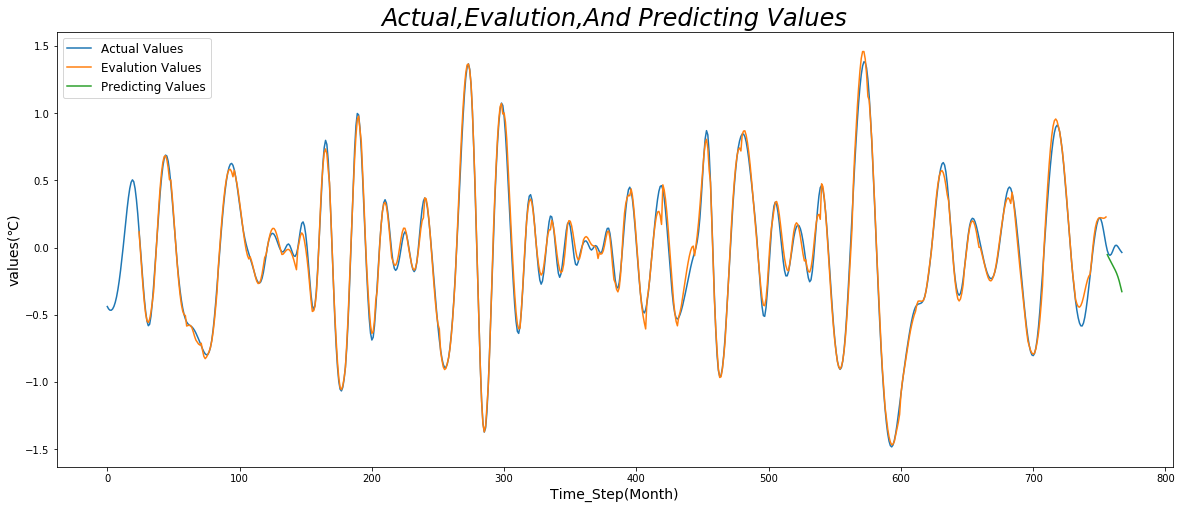

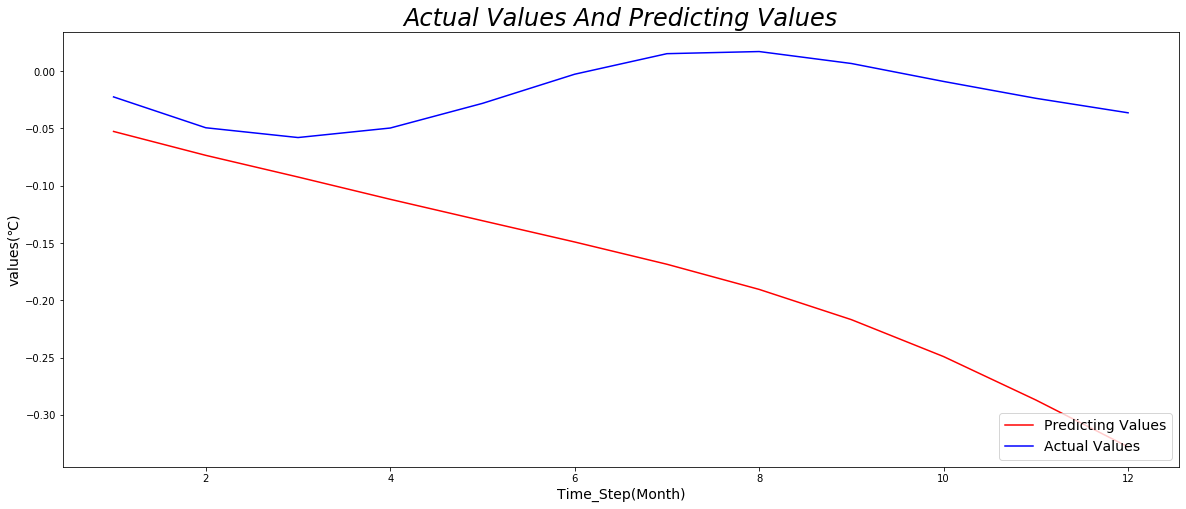

0     -0.538450
1     -0.526230
2     -0.507350
3     -0.481980
4     -0.450610
5     -0.413780
6     -0.372030
7     -0.325890
8     -0.275900
9     -0.222610
10    -0.166550
11    -0.108270
12    -0.048294
13     0.012829
14     0.074562
15     0.136370
16     0.197700
17     0.258030
18     0.316810
19     0.373510
20     0.427580
21     0.478490
22     0.525830
23     0.569200
24     0.608230
25     0.642540
26     0.671750
27     0.695490
28     0.713370
29     0.725020
         ...   
738   -0.110200
739   -0.082479
740   -0.050654
741   -0.015994
742    0.020232
743    0.056753
744    0.092297
745    0.125590
746    0.155370
747    0.180360
748    0.199290
749    0.210890
750    0.213890
751    0.207050
752    0.189680
753    0.162600
754    0.127040
755    0.084259
756    0.035490
757   -0.018022
758   -0.075032
759   -0.134110
760   -0.192950
761   -0.248230
762   -0.295680
763   -0.331570
764   -0.355150
765   -0.366600
766   -0.366600
767   -0.356020
Name: f3, Length: 768, d

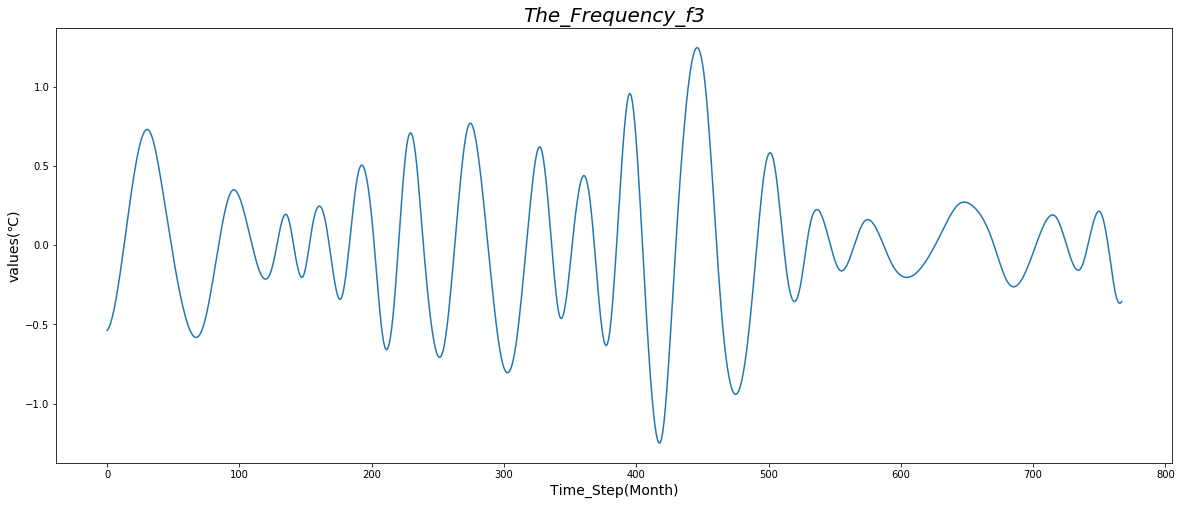

[[[-5.3845e-01]
  [-5.2623e-01]
  [-5.0735e-01]
  [-4.8198e-01]
  [-4.5061e-01]
  [-4.1378e-01]
  [-3.7203e-01]
  [-3.2589e-01]
  [-2.7590e-01]
  [-2.2261e-01]
  [-1.6655e-01]
  [-1.0827e-01]]

 [[-4.8294e-02]
  [ 1.2829e-02]
  [ 7.4562e-02]
  [ 1.3637e-01]
  [ 1.9770e-01]
  [ 2.5803e-01]
  [ 3.1681e-01]
  [ 3.7351e-01]
  [ 4.2758e-01]
  [ 4.7849e-01]
  [ 5.2583e-01]
  [ 5.6920e-01]]

 [[ 6.0823e-01]
  [ 6.4254e-01]
  [ 6.7175e-01]
  [ 6.9549e-01]
  [ 7.1337e-01]
  [ 7.2502e-01]
  [ 7.3005e-01]
  [ 7.2810e-01]
  [ 7.1888e-01]
  [ 7.0263e-01]
  [ 6.7994e-01]
  [ 6.5140e-01]]

 [[ 6.1765e-01]
  [ 5.7930e-01]
  [ 5.3698e-01]
  [ 4.9129e-01]
  [ 4.4287e-01]
  [ 3.9232e-01]
  [ 3.4028e-01]
  [ 2.8736e-01]
  [ 2.3413e-01]
  [ 1.8096e-01]
  [ 1.2808e-01]
  [ 7.5673e-02]]

 [[ 2.3922e-02]
  [-2.6981e-02]
  [-7.6848e-02]
  [-1.2549e-01]
  [-1.7272e-01]
  [-2.1835e-01]
  [-2.6219e-01]
  [-3.0405e-01]
  [-3.4374e-01]
  [-3.8107e-01]
  [-4.1587e-01]
  [-4.4793e-01]]

 [[-4.7707e-01]
  [-5.0310e-01

Epoch 1/200
 - 9s - loss: 0.1517
Epoch 2/200
 - 3s - loss: 0.1107
Epoch 3/200
 - 2s - loss: 0.0815
Epoch 4/200
 - 2s - loss: 0.0562
Epoch 5/200
 - 2s - loss: 0.0464
Epoch 6/200
 - 2s - loss: 0.0347
Epoch 7/200
 - 2s - loss: 0.0332
Epoch 8/200
 - 2s - loss: 0.0222
Epoch 9/200
 - 2s - loss: 0.0227
Epoch 10/200
 - 2s - loss: 0.0195
Epoch 11/200
 - 2s - loss: 0.0194
Epoch 12/200
 - 2s - loss: 0.0251
Epoch 13/200
 - 2s - loss: 0.0189
Epoch 14/200
 - 2s - loss: 0.0161
Epoch 15/200
 - 2s - loss: 0.0113
Epoch 16/200
 - 2s - loss: 0.0112
Epoch 17/200
 - 2s - loss: 0.0119
Epoch 18/200
 - 2s - loss: 0.0118
Epoch 19/200
 - 2s - loss: 0.0093
Epoch 20/200
 - 2s - loss: 0.0103
Epoch 21/200
 - 2s - loss: 0.0096
Epoch 22/200
 - 2s - loss: 0.0104
Epoch 23/200
 - 2s - loss: 0.0089
Epoch 24/200
 - 2s - loss: 0.0100
Epoch 25/200
 - 2s - loss: 0.0075
Epoch 26/200
 - 2s - loss: 0.0090
Epoch 27/200
 - 2s - loss: 0.0074
Epoch 28/200
 - 2s - loss: 0.0073
Epoch 29/200
 - 2s - loss: 0.0075
Epoch 30/200
 - 2s - lo

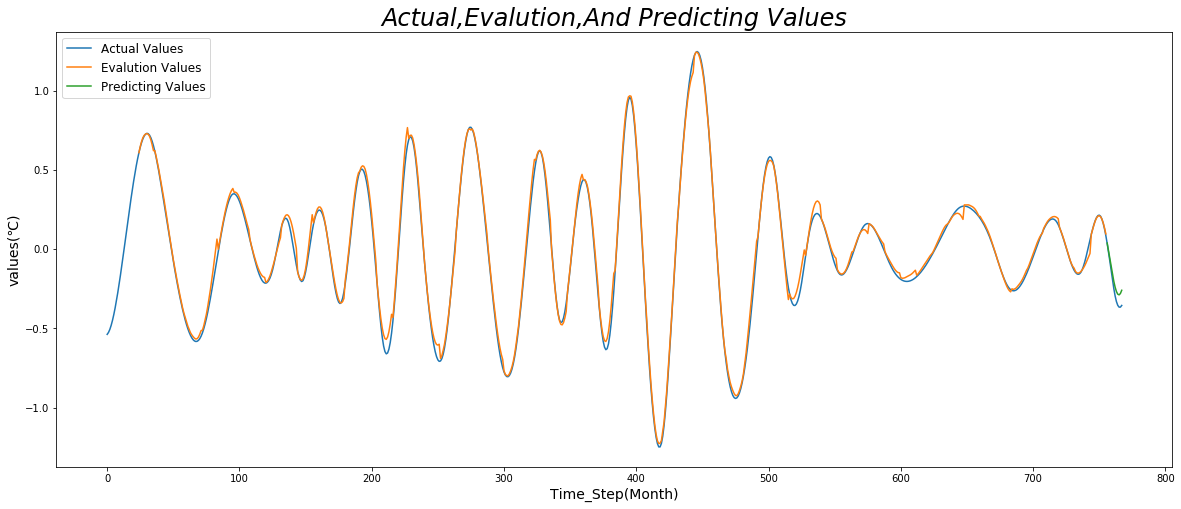

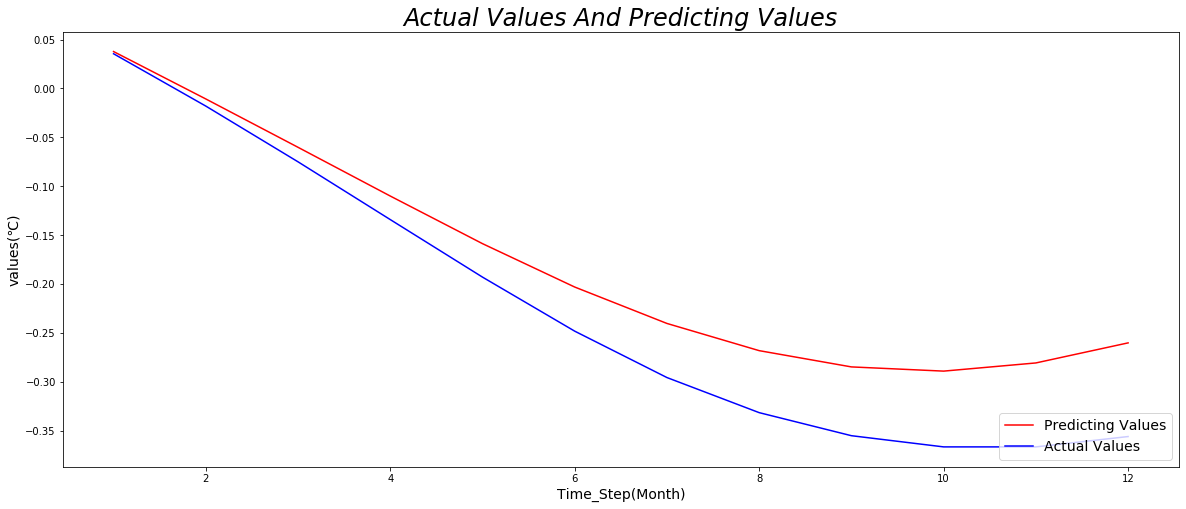

0     -0.215810
1     -0.214380
2     -0.212910
3     -0.211390
4     -0.209820
5     -0.208200
6     -0.206530
7     -0.204810
8     -0.203030
9     -0.201200
10    -0.199310
11    -0.197360
12    -0.195360
13    -0.193290
14    -0.191160
15    -0.188960
16    -0.186700
17    -0.184380
18    -0.181980
19    -0.179520
20    -0.176990
21    -0.174390
22    -0.171710
23    -0.168960
24    -0.166130
25    -0.163230
26    -0.160250
27    -0.157190
28    -0.154050
29    -0.150820
         ...   
738   -0.427060
739   -0.426350
740   -0.424430
741   -0.421260
742   -0.416830
743   -0.411120
744   -0.404120
745   -0.395790
746   -0.386130
747   -0.375120
748   -0.362730
749   -0.348960
750   -0.333770
751   -0.317160
752   -0.299200
753   -0.279950
754   -0.259550
755   -0.238100
756   -0.215740
757   -0.192600
758   -0.168800
759   -0.144460
760   -0.119720
761   -0.094688
762   -0.069505
763   -0.044291
764   -0.019166
765    0.005776
766    0.030458
767    0.054833
Name: f4, Length: 768, d

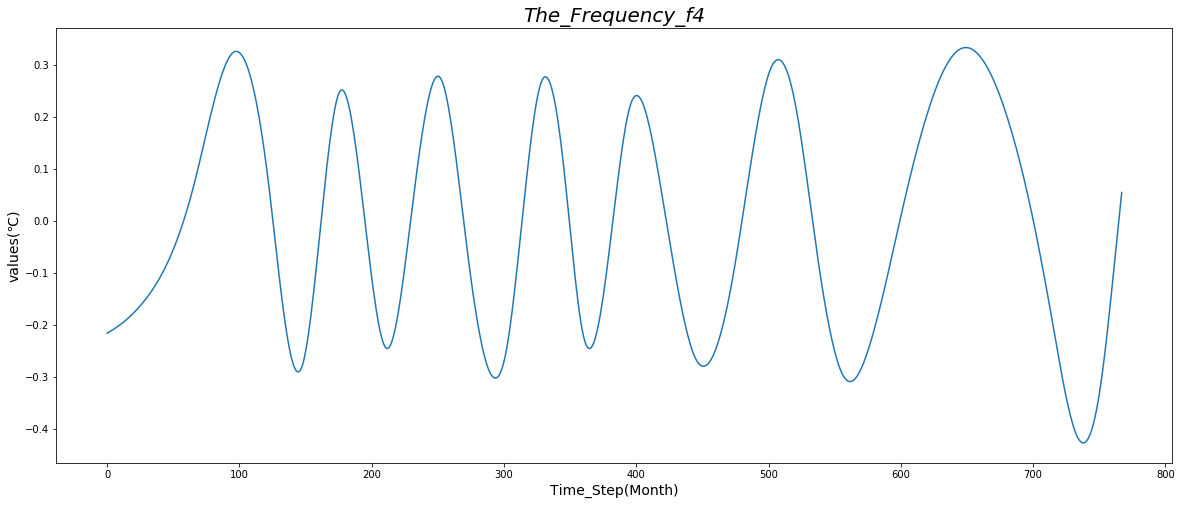

[[[-0.21581  ]
  [-0.21438  ]
  [-0.21291  ]
  [-0.21139  ]
  [-0.20982  ]
  [-0.2082   ]
  [-0.20653  ]
  [-0.20481  ]
  [-0.20303  ]
  [-0.2012   ]
  [-0.19931  ]
  [-0.19736  ]]

 [[-0.19536  ]
  [-0.19329  ]
  [-0.19116  ]
  [-0.18896  ]
  [-0.1867   ]
  [-0.18438  ]
  [-0.18198  ]
  [-0.17952  ]
  [-0.17699  ]
  [-0.17439  ]
  [-0.17171  ]
  [-0.16896  ]]

 [[-0.16613  ]
  [-0.16323  ]
  [-0.16025  ]
  [-0.15719  ]
  [-0.15405  ]
  [-0.15082  ]
  [-0.14752  ]
  [-0.14412  ]
  [-0.14063  ]
  [-0.13703  ]
  [-0.13331  ]
  [-0.12948  ]]

 [[-0.12553  ]
  [-0.12146  ]
  [-0.11725  ]
  [-0.11291  ]
  [-0.10842  ]
  [-0.10379  ]
  [-0.099013 ]
  [-0.094078 ]
  [-0.088983 ]
  [-0.083723 ]
  [-0.078293 ]
  [-0.072689 ]]

 [[-0.066905 ]
  [-0.060937 ]
  [-0.054779 ]
  [-0.048428 ]
  [-0.041877 ]
  [-0.035123 ]
  [-0.028161 ]
  [-0.020985 ]
  [-0.01359  ]
  [-0.0059729]
  [ 0.0018726]
  [ 0.0099509]]

 [[ 0.018267 ]
  [ 0.026826 ]
  [ 0.035632 ]
  [ 0.04469  ]
  [ 0.054005 ]
  [ 0.06358  ]


Epoch 1/200
 - 10s - loss: 0.0331
Epoch 2/200
 - 3s - loss: 0.0098
Epoch 3/200
 - 2s - loss: 0.0055
Epoch 4/200
 - 2s - loss: 0.0034
Epoch 5/200
 - 2s - loss: 0.0021
Epoch 6/200
 - 2s - loss: 0.0014
Epoch 7/200
 - 2s - loss: 0.0011
Epoch 8/200
 - 2s - loss: 0.0011
Epoch 9/200
 - 2s - loss: 0.0011
Epoch 10/200
 - 2s - loss: 0.0011
Epoch 11/200
 - 2s - loss: 0.0013
Epoch 12/200
 - 2s - loss: 8.3415e-04
Epoch 13/200
 - 2s - loss: 6.7308e-04
Epoch 14/200
 - 2s - loss: 6.7908e-04
Epoch 15/200
 - 2s - loss: 8.9391e-04
Epoch 16/200
 - 2s - loss: 6.2523e-04
Epoch 17/200
 - 2s - loss: 5.4693e-04
Epoch 18/200
 - 2s - loss: 6.1847e-04
Epoch 19/200
 - 2s - loss: 6.9328e-04
Epoch 20/200
 - 2s - loss: 7.1662e-04
Epoch 21/200
 - 2s - loss: 6.9052e-04
Epoch 22/200
 - 2s - loss: 8.7922e-04
Epoch 23/200
 - 2s - loss: 5.3784e-04
Epoch 24/200
 - 2s - loss: 4.5869e-04
Epoch 25/200
 - 2s - loss: 4.4224e-04
Epoch 26/200
 - 2s - loss: 3.7585e-04
Epoch 27/200
 - 2s - loss: 3.7644e-04
Epoch 28/200
 - 2s - loss:

(61, 12)


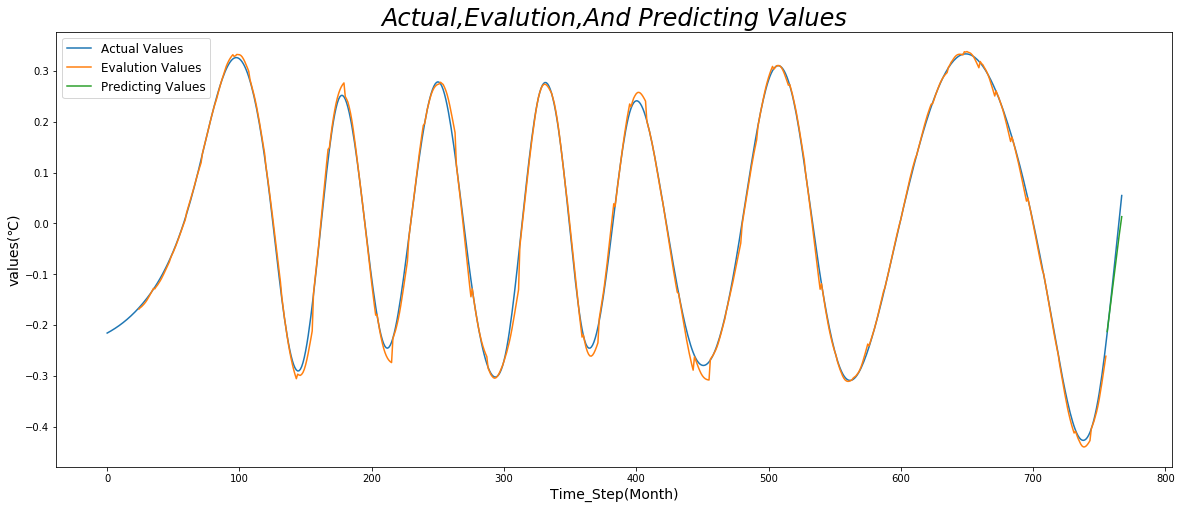

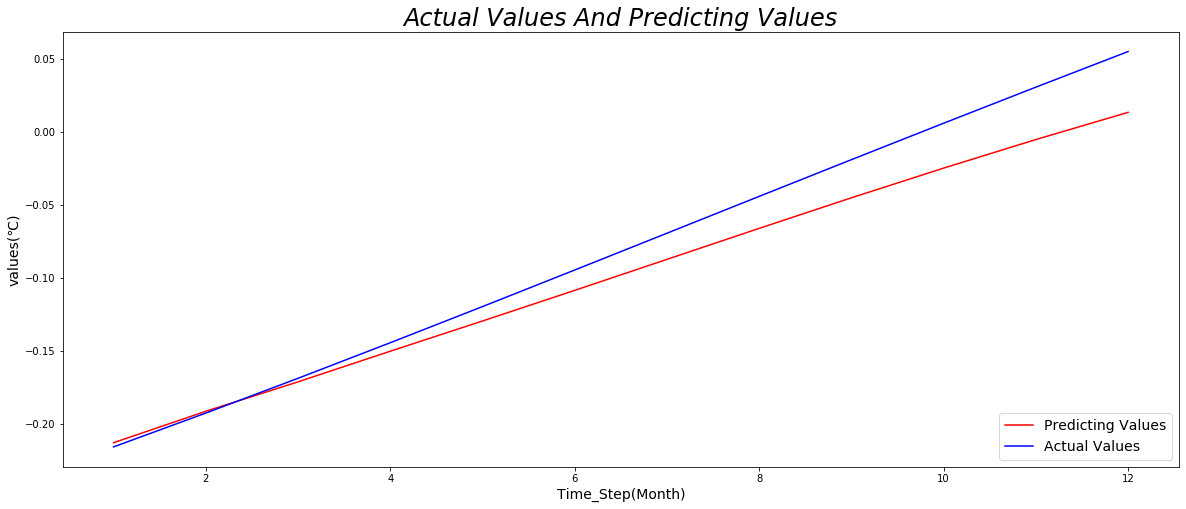

0      0.004482
1      0.003265
2      0.002159
3      0.001161
4      0.000266
5     -0.000529
6     -0.001226
7     -0.001830
8     -0.002343
9     -0.002768
10    -0.003109
11    -0.003368
12    -0.003548
13    -0.003654
14    -0.003686
15    -0.003650
16    -0.003548
17    -0.003384
18    -0.003162
19    -0.002884
20    -0.002554
21    -0.002177
22    -0.001754
23    -0.001289
24    -0.000785
25    -0.000244
26     0.000330
27     0.000934
28     0.001566
29     0.002224
         ...   
738   -0.034286
739   -0.030572
740   -0.026831
741   -0.023065
742   -0.019278
743   -0.015472
744   -0.011649
745   -0.007813
746   -0.003965
747   -0.000109
748    0.003754
749    0.007620
750    0.011488
751    0.015353
752    0.019215
753    0.023069
754    0.026914
755    0.030748
756    0.034566
757    0.038368
758    0.042150
759    0.045909
760    0.049644
761    0.053351
762    0.057028
763    0.060672
764    0.064282
765    0.067853
766    0.071384
767    0.074872
Name: f5, Length: 768, d

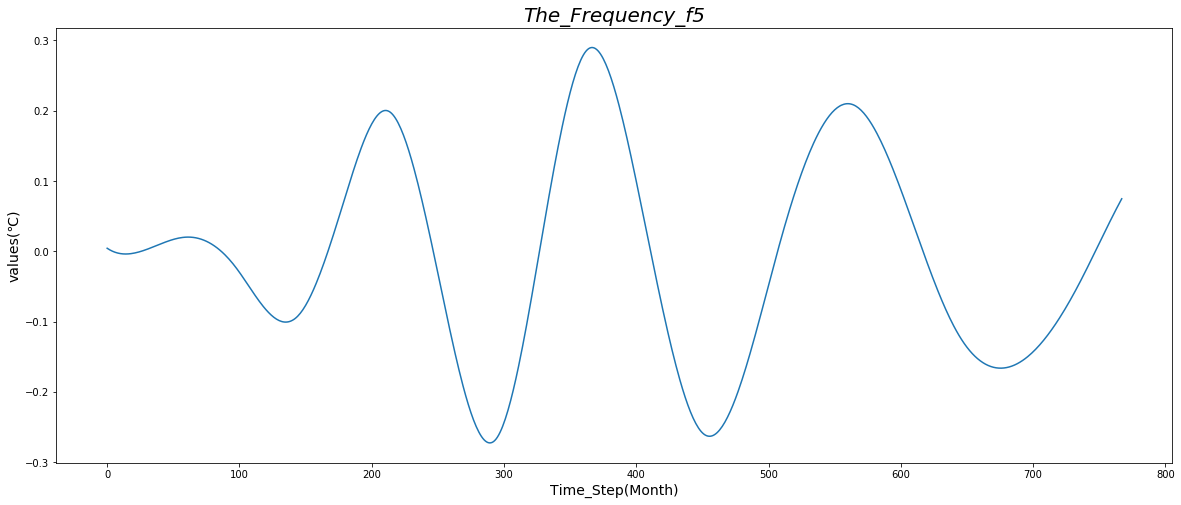

[[[ 4.4815e-03]
  [ 3.2649e-03]
  [ 2.1594e-03]
  [ 1.1610e-03]
  [ 2.6607e-04]
  [-5.2874e-04]
  [-1.2265e-03]
  [-1.8303e-03]
  [-2.3432e-03]
  [-2.7684e-03]
  [-3.1089e-03]
  [-3.3678e-03]]

 [[-3.5483e-03]
  [-3.6535e-03]
  [-3.6864e-03]
  [-3.6501e-03]
  [-3.5482e-03]
  [-3.3842e-03]
  [-3.1616e-03]
  [-2.8838e-03]
  [-2.5544e-03]
  [-2.1766e-03]
  [-1.7537e-03]
  [-1.2888e-03]]

 [[-7.8468e-04]
  [-2.4422e-04]
  [ 3.2968e-04]
  [ 9.3417e-04]
  [ 1.5665e-03]
  [ 2.2240e-03]
  [ 2.9039e-03]
  [ 3.6035e-03]
  [ 4.3202e-03]
  [ 5.0511e-03]
  [ 5.7937e-03]
  [ 6.5452e-03]]

 [[ 7.3028e-03]
  [ 8.0640e-03]
  [ 8.8259e-03]
  [ 9.5859e-03]
  [ 1.0341e-02]
  [ 1.1089e-02]
  [ 1.1827e-02]
  [ 1.2552e-02]
  [ 1.3262e-02]
  [ 1.3954e-02]
  [ 1.4624e-02]
  [ 1.5271e-02]]

 [[ 1.5892e-02]
  [ 1.6484e-02]
  [ 1.7044e-02]
  [ 1.7570e-02]
  [ 1.8058e-02]
  [ 1.8507e-02]
  [ 1.8913e-02]
  [ 1.9274e-02]
  [ 1.9587e-02]
  [ 1.9850e-02]
  [ 2.0061e-02]
  [ 2.0217e-02]]

 [[ 2.0317e-02]
  [ 2.0360e-02

Epoch 1/200
 - 9s - loss: 0.0117
Epoch 2/200
 - 3s - loss: 0.0028
Epoch 3/200
 - 3s - loss: 8.1306e-04
Epoch 4/200
 - 2s - loss: 3.2026e-04
Epoch 5/200
 - 2s - loss: 2.2914e-04
Epoch 6/200
 - 2s - loss: 1.6639e-04
Epoch 7/200
 - 2s - loss: 8.4926e-05
Epoch 8/200
 - 2s - loss: 1.2869e-04
Epoch 9/200
 - 2s - loss: 1.1861e-04
Epoch 10/200
 - 2s - loss: 1.2608e-04
Epoch 11/200
 - 2s - loss: 1.1574e-04
Epoch 12/200
 - 2s - loss: 6.3358e-05
Epoch 13/200
 - 2s - loss: 5.4815e-05
Epoch 14/200
 - 2s - loss: 6.7668e-05
Epoch 15/200
 - 2s - loss: 5.8414e-05
Epoch 16/200
 - 2s - loss: 5.7139e-05
Epoch 17/200
 - 2s - loss: 5.4108e-05
Epoch 18/200
 - 4s - loss: 6.8356e-05
Epoch 19/200
 - 3s - loss: 7.1621e-05
Epoch 20/200
 - 2s - loss: 7.7131e-05
Epoch 21/200
 - 2s - loss: 7.5123e-05
Epoch 22/200
 - 2s - loss: 1.0985e-04
Epoch 23/200
 - 2s - loss: 1.5147e-04
Epoch 24/200
 - 2s - loss: 4.0570e-05
Epoch 25/200
 - 2s - loss: 4.5206e-05
Epoch 26/200
 - 2s - loss: 6.4118e-05
Epoch 27/200
 - 2s - loss: 2.

(61, 12)


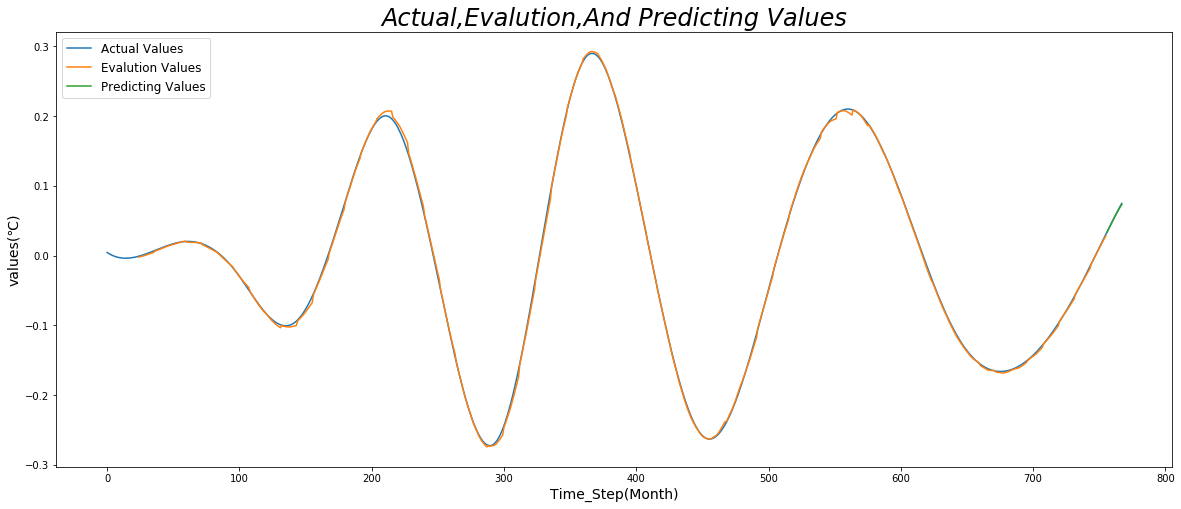

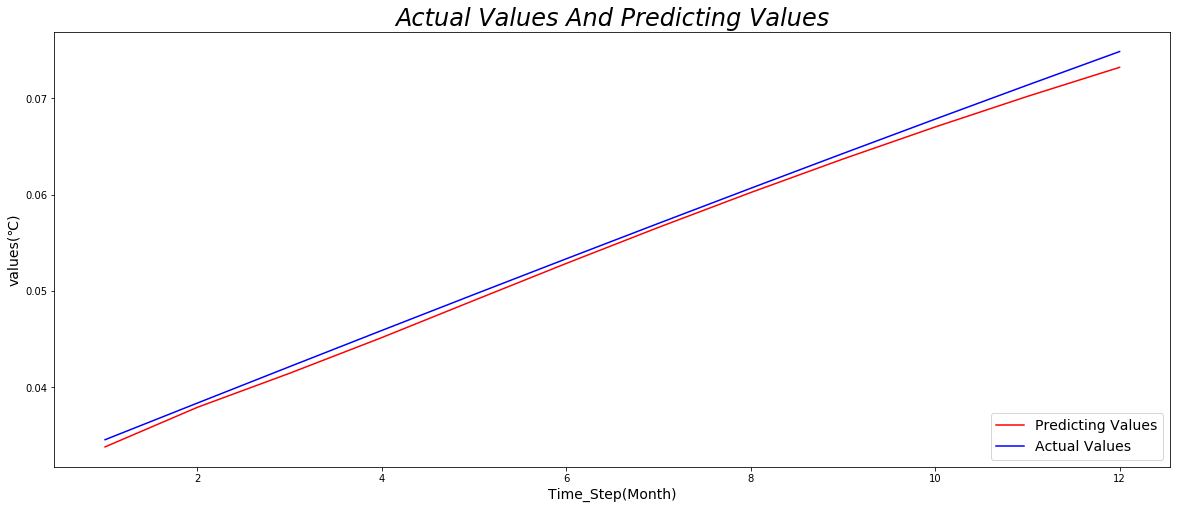

0     -0.12887
1     -0.12956
2     -0.13022
3     -0.13084
4     -0.13142
5     -0.13198
6     -0.13249
7     -0.13297
8     -0.13342
9     -0.13382
10    -0.13418
11    -0.13451
12    -0.13479
13    -0.13504
14    -0.13524
15    -0.13539
16    -0.13551
17    -0.13557
18    -0.13559
19    -0.13557
20    -0.13549
21    -0.13536
22    -0.13519
23    -0.13496
24    -0.13468
25    -0.13434
26    -0.13395
27    -0.13351
28    -0.13302
29    -0.13247
        ...   
738   -0.17432
739   -0.17305
740   -0.17178
741   -0.17049
742   -0.16920
743   -0.16791
744   -0.16660
745   -0.16529
746   -0.16397
747   -0.16264
748   -0.16131
749   -0.15998
750   -0.15864
751   -0.15729
752   -0.15594
753   -0.15459
754   -0.15323
755   -0.15187
756   -0.15051
757   -0.14914
758   -0.14778
759   -0.14641
760   -0.14504
761   -0.14367
762   -0.14230
763   -0.14093
764   -0.13956
765   -0.13819
766   -0.13682
767   -0.13545
Name: f6, Length: 768, dtype: float64
(768,)


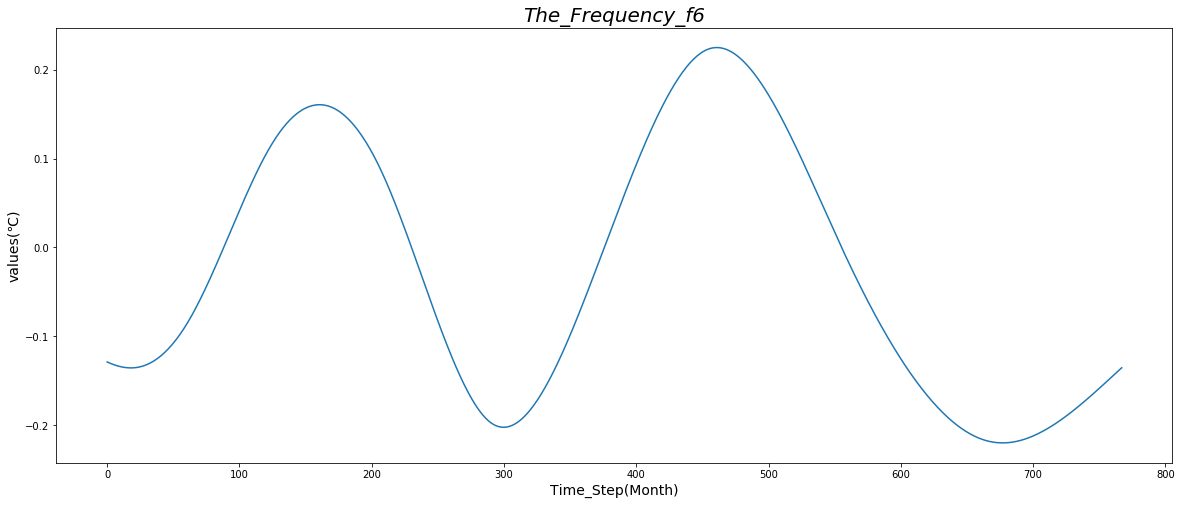

[[[-0.12887   ]
  [-0.12956   ]
  [-0.13022   ]
  [-0.13084   ]
  [-0.13142   ]
  [-0.13198   ]
  [-0.13249   ]
  [-0.13297   ]
  [-0.13342   ]
  [-0.13382   ]
  [-0.13418   ]
  [-0.13451   ]]

 [[-0.13479   ]
  [-0.13504   ]
  [-0.13524   ]
  [-0.13539   ]
  [-0.13551   ]
  [-0.13557   ]
  [-0.13559   ]
  [-0.13557   ]
  [-0.13549   ]
  [-0.13536   ]
  [-0.13519   ]
  [-0.13496   ]]

 [[-0.13468   ]
  [-0.13434   ]
  [-0.13395   ]
  [-0.13351   ]
  [-0.13302   ]
  [-0.13247   ]
  [-0.13187   ]
  [-0.13121   ]
  [-0.13049   ]
  [-0.12972   ]
  [-0.12889   ]
  [-0.12801   ]]

 [[-0.12707   ]
  [-0.12608   ]
  [-0.12502   ]
  [-0.12391   ]
  [-0.12274   ]
  [-0.12151   ]
  [-0.12022   ]
  [-0.11888   ]
  [-0.11747   ]
  [-0.116     ]
  [-0.11448   ]
  [-0.11289   ]]

 [[-0.11124   ]
  [-0.10953   ]
  [-0.10776   ]
  [-0.10593   ]
  [-0.10404   ]
  [-0.10208   ]
  [-0.10006   ]
  [-0.097974  ]
  [-0.095827  ]
  [-0.093616  ]
  [-0.091342  ]
  [-0.089005  ]]

 [[-0.086605  ]
  [-0.084145  

Epoch 1/200
 - 8s - loss: 0.0087
Epoch 2/200
 - 2s - loss: 0.0027
Epoch 3/200
 - 2s - loss: 0.0013
Epoch 4/200
 - 2s - loss: 4.3283e-04
Epoch 5/200
 - 2s - loss: 2.5363e-04
Epoch 6/200
 - 2s - loss: 5.9521e-05
Epoch 7/200
 - 2s - loss: 2.9954e-05
Epoch 8/200
 - 2s - loss: 2.0065e-05
Epoch 9/200
 - 2s - loss: 1.7301e-05
Epoch 10/200
 - 2s - loss: 1.6177e-05
Epoch 11/200
 - 2s - loss: 2.9600e-05
Epoch 12/200
 - 2s - loss: 3.5410e-05
Epoch 13/200
 - 2s - loss: 3.7248e-05
Epoch 14/200
 - 2s - loss: 3.8562e-05
Epoch 15/200
 - 2s - loss: 2.3765e-05
Epoch 16/200
 - 2s - loss: 1.9319e-05
Epoch 17/200
 - 2s - loss: 1.3356e-05
Epoch 18/200
 - 2s - loss: 1.3961e-05
Epoch 19/200
 - 2s - loss: 1.8389e-05
Epoch 20/200
 - 2s - loss: 1.6824e-05
Epoch 21/200
 - 2s - loss: 1.9859e-05
Epoch 22/200
 - 2s - loss: 1.1238e-05
Epoch 23/200
 - 2s - loss: 1.6492e-05
Epoch 24/200
 - 2s - loss: 1.5899e-05
Epoch 25/200
 - 2s - loss: 1.1536e-05
Epoch 26/200
 - 2s - loss: 2.8215e-05
Epoch 27/200
 - 2s - loss: 2.9624

(61, 12)


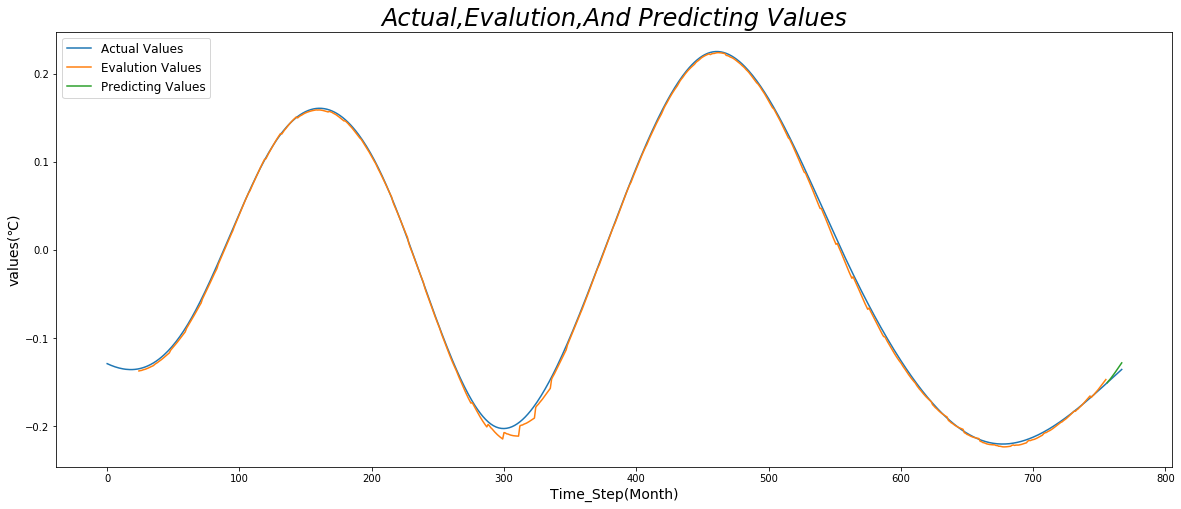

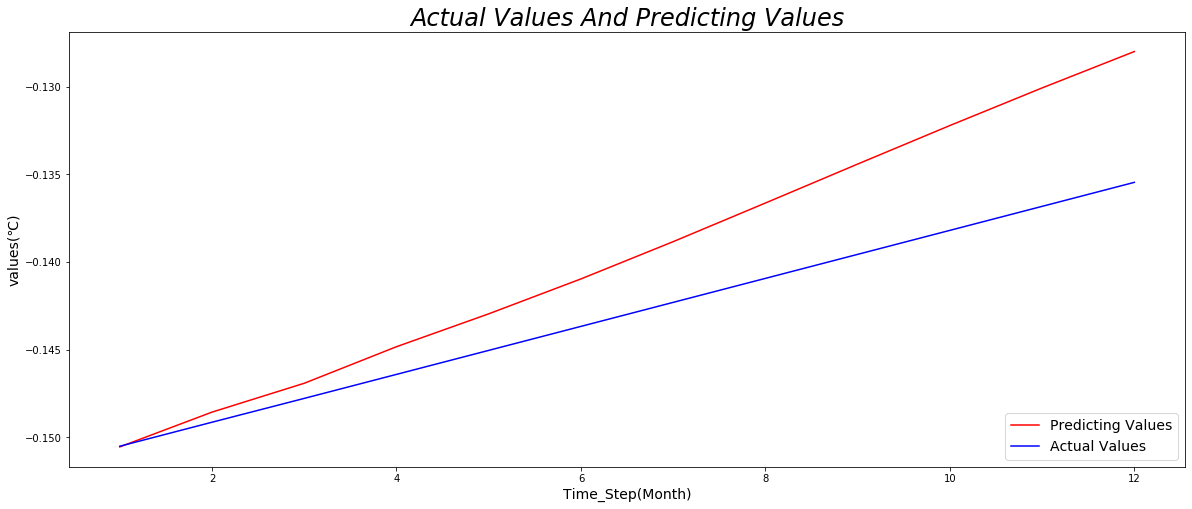

0      0.051841
1      0.051858
2      0.051870
3      0.051877
4      0.051878
5      0.051875
6      0.051866
7      0.051851
8      0.051832
9      0.051807
10     0.051776
11     0.051741
12     0.051700
13     0.051653
14     0.051601
15     0.051543
16     0.051480
17     0.051411
18     0.051337
19     0.051257
20     0.051172
21     0.051081
22     0.050984
23     0.050882
24     0.050774
25     0.050660
26     0.050542
27     0.050418
28     0.050288
29     0.050153
         ...   
738    0.042512
739    0.042414
740    0.042314
741    0.042211
742    0.042107
743    0.041999
744    0.041890
745    0.041778
746    0.041663
747    0.041546
748    0.041427
749    0.041306
750    0.041182
751    0.041056
752    0.040928
753    0.040797
754    0.040665
755    0.040530
756    0.040392
757    0.040253
758    0.040111
759    0.039967
760    0.039821
761    0.039673
762    0.039523
763    0.039371
764    0.039216
765    0.039059
766    0.038901
767    0.038740
Name: f7, Length: 768, d

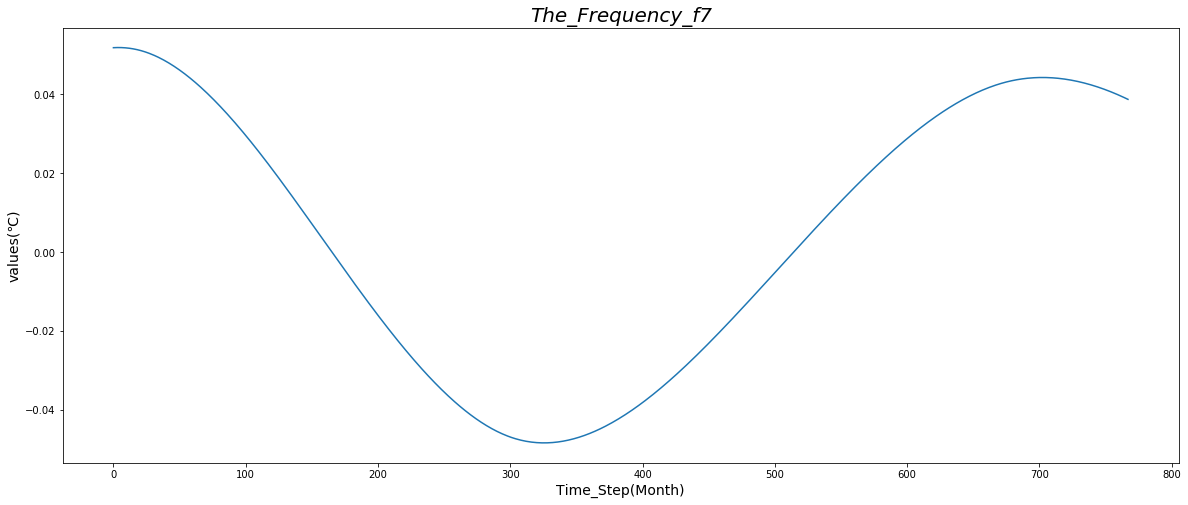

[[[ 5.1841e-02]
  [ 5.1858e-02]
  [ 5.1870e-02]
  [ 5.1877e-02]
  [ 5.1878e-02]
  [ 5.1875e-02]
  [ 5.1866e-02]
  [ 5.1851e-02]
  [ 5.1832e-02]
  [ 5.1807e-02]
  [ 5.1776e-02]
  [ 5.1741e-02]]

 [[ 5.1700e-02]
  [ 5.1653e-02]
  [ 5.1601e-02]
  [ 5.1543e-02]
  [ 5.1480e-02]
  [ 5.1411e-02]
  [ 5.1337e-02]
  [ 5.1257e-02]
  [ 5.1172e-02]
  [ 5.1081e-02]
  [ 5.0984e-02]
  [ 5.0882e-02]]

 [[ 5.0774e-02]
  [ 5.0660e-02]
  [ 5.0542e-02]
  [ 5.0418e-02]
  [ 5.0288e-02]
  [ 5.0153e-02]
  [ 5.0013e-02]
  [ 4.9868e-02]
  [ 4.9718e-02]
  [ 4.9562e-02]
  [ 4.9402e-02]
  [ 4.9236e-02]]

 [[ 4.9065e-02]
  [ 4.8889e-02]
  [ 4.8709e-02]
  [ 4.8523e-02]
  [ 4.8333e-02]
  [ 4.8138e-02]
  [ 4.7938e-02]
  [ 4.7733e-02]
  [ 4.7524e-02]
  [ 4.7310e-02]
  [ 4.7091e-02]
  [ 4.6868e-02]]

 [[ 4.6640e-02]
  [ 4.6408e-02]
  [ 4.6171e-02]
  [ 4.5930e-02]
  [ 4.5685e-02]
  [ 4.5435e-02]
  [ 4.5181e-02]
  [ 4.4923e-02]
  [ 4.4660e-02]
  [ 4.4394e-02]
  [ 4.4123e-02]
  [ 4.3848e-02]]

 [[ 4.3570e-02]
  [ 4.3287e-02

Epoch 1/200
 - 9s - loss: 0.0010
Epoch 2/200
 - 3s - loss: 2.6602e-04
Epoch 3/200
 - 2s - loss: 1.3155e-04
Epoch 4/200
 - 2s - loss: 8.1860e-05
Epoch 5/200
 - 2s - loss: 6.7881e-05
Epoch 6/200
 - 2s - loss: 5.4291e-05
Epoch 7/200
 - 2s - loss: 4.1120e-05
Epoch 8/200
 - 2s - loss: 3.2821e-05
Epoch 9/200
 - 2s - loss: 2.9658e-05
Epoch 10/200
 - 2s - loss: 2.6888e-05
Epoch 11/200
 - 2s - loss: 2.6568e-05
Epoch 12/200
 - 2s - loss: 2.3996e-05
Epoch 13/200
 - 2s - loss: 2.1566e-05
Epoch 14/200
 - 2s - loss: 1.7055e-05
Epoch 15/200
 - 2s - loss: 1.5435e-05
Epoch 16/200
 - 2s - loss: 1.3094e-05
Epoch 17/200
 - 2s - loss: 1.3000e-05
Epoch 18/200
 - 2s - loss: 7.1340e-06
Epoch 19/200
 - 2s - loss: 1.4294e-05
Epoch 20/200
 - 2s - loss: 1.6294e-05
Epoch 21/200
 - 2s - loss: 7.7268e-06
Epoch 22/200
 - 2s - loss: 2.0686e-06
Epoch 23/200
 - 2s - loss: 1.5252e-06
Epoch 24/200
 - 2s - loss: 8.3787e-07
Epoch 25/200
 - 2s - loss: 6.7433e-07
Epoch 26/200
 - 2s - loss: 1.1714e-06
Epoch 27/200
 - 2s - loss

(61, 12)


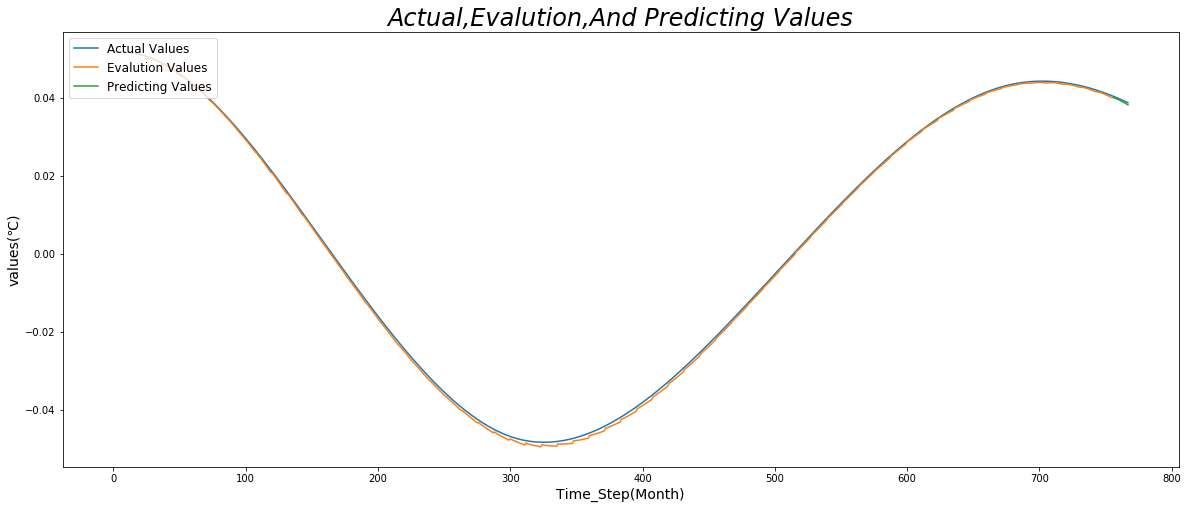

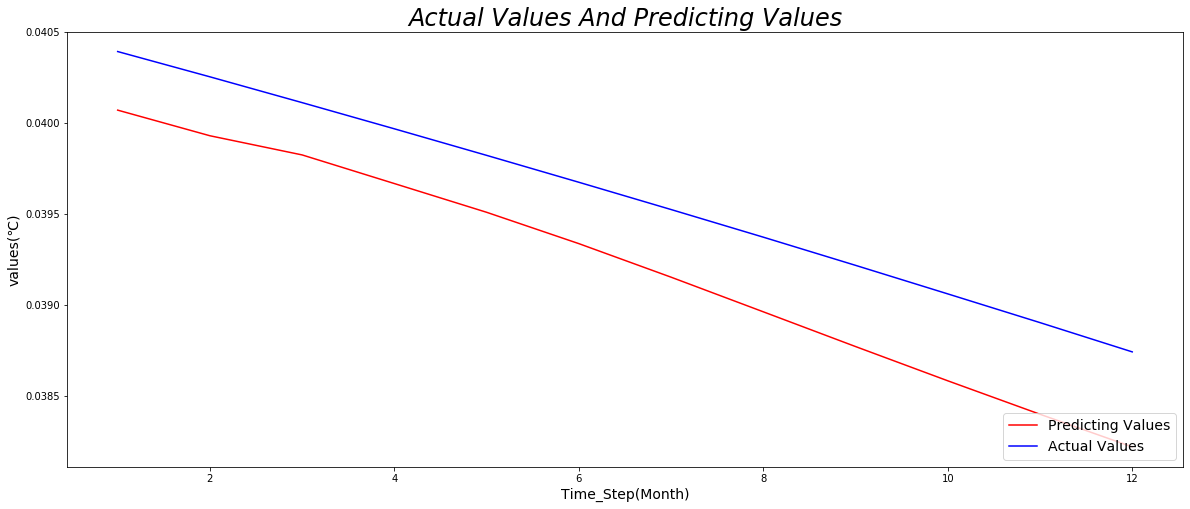

0      0.085791
1      0.085784
2      0.085777
3      0.085769
4      0.085762
5      0.085755
6      0.085747
7      0.085740
8      0.085733
9      0.085725
10     0.085718
11     0.085710
12     0.085703
13     0.085695
14     0.085687
15     0.085680
16     0.085672
17     0.085664
18     0.085657
19     0.085649
20     0.085641
21     0.085633
22     0.085625
23     0.085618
24     0.085610
25     0.085602
26     0.085594
27     0.085586
28     0.085578
29     0.085570
         ...   
738    0.077930
739    0.077924
740    0.077918
741    0.077912
742    0.077906
743    0.077900
744    0.077895
745    0.077889
746    0.077883
747    0.077877
748    0.077872
749    0.077866
750    0.077861
751    0.077855
752    0.077849
753    0.077844
754    0.077838
755    0.077833
756    0.077828
757    0.077822
758    0.077817
759    0.077812
760    0.077806
761    0.077801
762    0.077796
763    0.077791
764    0.077786
765    0.077781
766    0.077776
767    0.077771
Name: f8, Length: 768, d

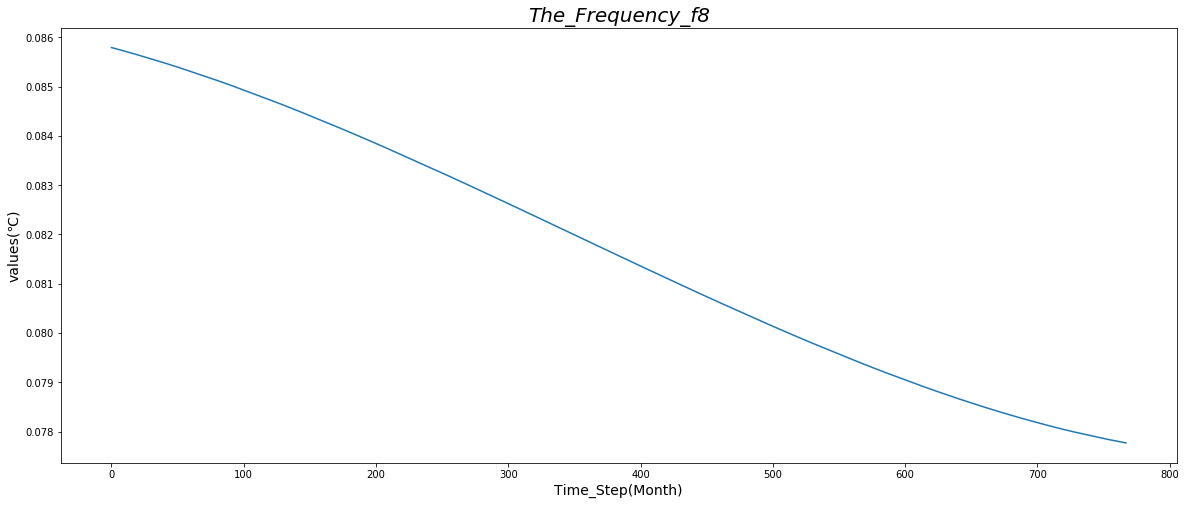

[[[0.085791]
  [0.085784]
  [0.085777]
  [0.085769]
  [0.085762]
  [0.085755]
  [0.085747]
  [0.08574 ]
  [0.085733]
  [0.085725]
  [0.085718]
  [0.08571 ]]

 [[0.085703]
  [0.085695]
  [0.085687]
  [0.08568 ]
  [0.085672]
  [0.085664]
  [0.085657]
  [0.085649]
  [0.085641]
  [0.085633]
  [0.085625]
  [0.085618]]

 [[0.08561 ]
  [0.085602]
  [0.085594]
  [0.085586]
  [0.085578]
  [0.08557 ]
  [0.085562]
  [0.085554]
  [0.085545]
  [0.085537]
  [0.085529]
  [0.085521]]

 [[0.085513]
  [0.085504]
  [0.085496]
  [0.085488]
  [0.085479]
  [0.085471]
  [0.085463]
  [0.085454]
  [0.085446]
  [0.085437]
  [0.085429]
  [0.08542 ]]

 [[0.085411]
  [0.085403]
  [0.085394]
  [0.085386]
  [0.085377]
  [0.085368]
  [0.085359]
  [0.085351]
  [0.085342]
  [0.085333]
  [0.085324]
  [0.085315]]

 [[0.085306]
  [0.085297]
  [0.085289]
  [0.08528 ]
  [0.085271]
  [0.085262]
  [0.085252]
  [0.085243]
  [0.085234]
  [0.085225]
  [0.085216]
  [0.085207]]

 [[0.085198]
  [0.085188]
  [0.085179]
  [0.08517 ]


Epoch 1/200
 - 9s - loss: 5.8638e-04
Epoch 2/200
 - 3s - loss: 1.3424e-05
Epoch 3/200
 - 2s - loss: 6.7927e-06
Epoch 4/200
 - 2s - loss: 6.5750e-06
Epoch 5/200
 - 2s - loss: 6.1629e-06
Epoch 6/200
 - 2s - loss: 6.0368e-06
Epoch 7/200
 - 2s - loss: 6.3940e-06
Epoch 8/200
 - 2s - loss: 6.1449e-06
Epoch 9/200
 - 2s - loss: 6.5732e-06
Epoch 10/200
 - 2s - loss: 6.2497e-06
Epoch 11/200
 - 2s - loss: 5.8399e-06
Epoch 12/200
 - 2s - loss: 5.9744e-06
Epoch 13/200
 - 2s - loss: 6.2875e-06
Epoch 14/200
 - 2s - loss: 6.1036e-06
Epoch 15/200
 - 2s - loss: 5.9938e-06
Epoch 16/200
 - 2s - loss: 5.8799e-06
Epoch 17/200
 - 2s - loss: 6.1342e-06
Epoch 18/200
 - 2s - loss: 5.9583e-06
Epoch 19/200
 - 2s - loss: 5.8297e-06
Epoch 20/200
 - 2s - loss: 5.9528e-06
Epoch 21/200
 - 2s - loss: 5.9896e-06
Epoch 22/200
 - 2s - loss: 6.1840e-06
Epoch 23/200
 - 2s - loss: 5.7719e-06
Epoch 24/200
 - 2s - loss: 6.5628e-06
Epoch 25/200
 - 2s - loss: 6.3064e-06
Epoch 26/200
 - 2s - loss: 6.9774e-06
Epoch 27/200
 - 2s - 

(61, 12)


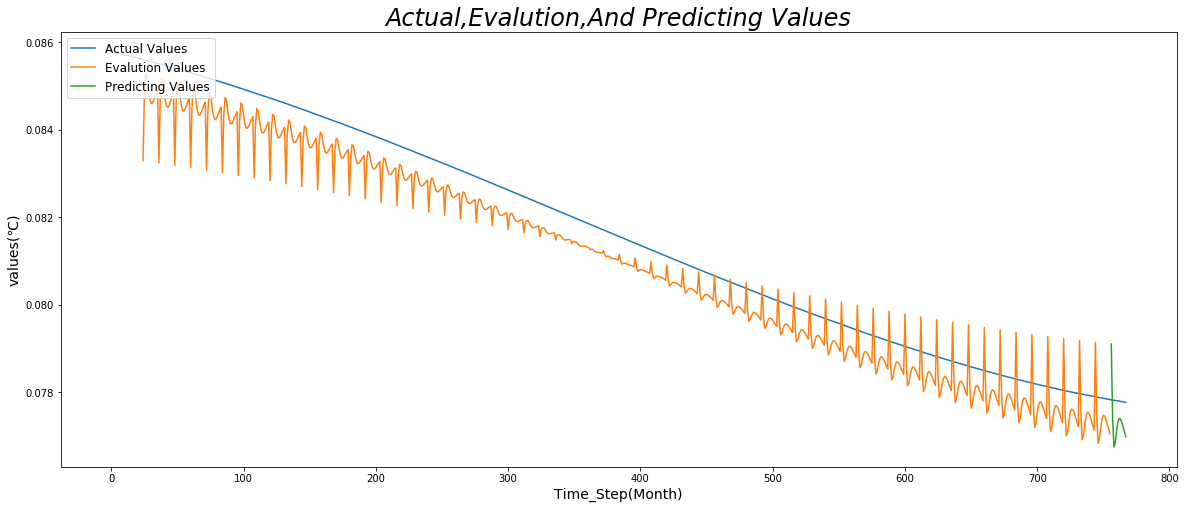

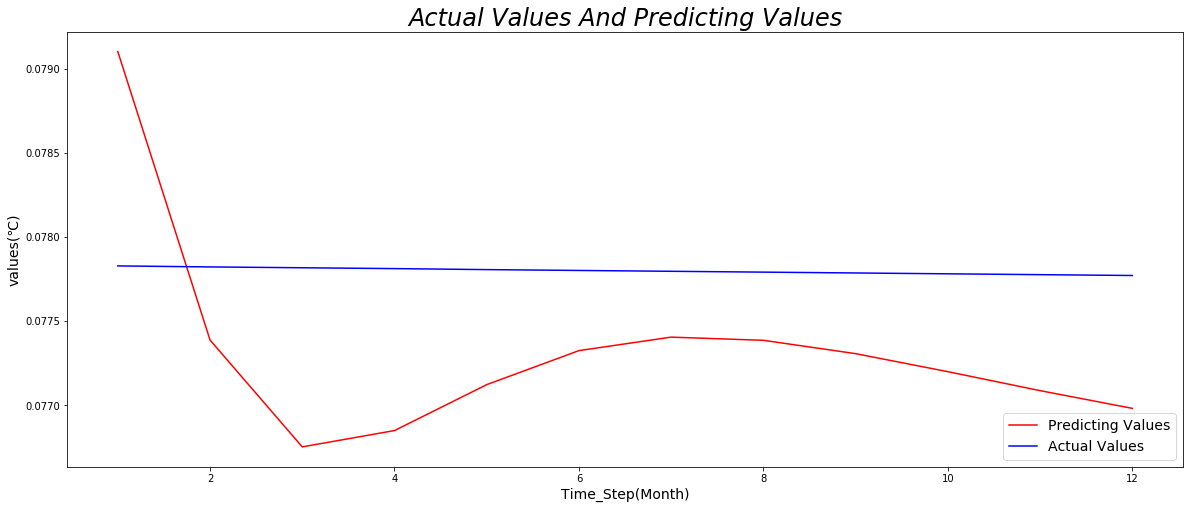

In [7]:
for i in range(9):
    index_name="f"+str(i)
    dataset = df[index_name][:-60]

    plt.figure(figsize=(20,8))
    plt.plot(dataset)
    plt.title('The_Frequency_{0}'.format(index_name),fontstyle="italic",fontsize=20)    
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/The_Frequency_{0}'.format(index_name))
    plt.show() 
    
    #train, test = split_dataset(dataset.values)
    #train=train.reshape(train.shape[0],train.shape[1],1)
    #test=test.reshape(test.shape[0],train.shape[1],1)
    train, test = split_dataset(dataset.values)
    train=train.reshape(train.shape[0],train.shape[1],1)
    test=test.reshape(test.shape[0],train.shape[1],1)

    n_steps, n_length = 2, 12
    n_input = n_length * n_steps
    n_out=12
    
    train_x, train_y = to_supervised(train, n_input,n_out)

    print (train_x.shape)
    
    model=build_model(train_x,train_y,n_input,n_out,n_steps, n_length)
    score, scores,predictions = evaluate_model(train, test, n_input,n_steps, n_length)
    
    
    #trainPredict = model.predict(train)
    #print (predictions.reshape(-1))
    
    trainPredict=[]
    for index_train_predict in range(train.shape[0]-2):
        input_x=train.reshape(-1)[12*index_train_predict:(index_train_predict+2)*12]
        input_x = input_x.reshape((1, n_steps,1,n_length, 1))
        yhat = model.predict(input_x, verbose=0)
        trainPredict.append(yhat)

    trainPredict=np.array(trainPredict)
    trainPredict=trainPredict.reshape(trainPredict.shape[0],trainPredict.shape[2])
    print (trainPredict.shape)


    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:] = np.nan
    #trainPredictPlot[12:len(trainPredict.reshape(-1))+12] = trainPredict.reshape(-1)
    trainPredictPlot[24:len(trainPredict.reshape(-1))+12*2] = trainPredict.reshape(-1)
    
# shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict.reshape(-1))+24:len(dataset)] = predictions.reshape(-1)
#testPredictPlot[len(trainPredict)+look_back+1:len(dataset)-1] = testPredict.reshape(-1)
# plot baseline and predictions

        
    plt.figure(figsize=(20,8))
    plt.title("Actual,Evalution,And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(dataset,label='Actual Values')
    plt.plot(trainPredictPlot,label='Evalution Values')
    plt.plot(testPredictPlot,label='Predicting Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=2,fontsize=12)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_whole_result_{0}.png'.format(index_name))
    plt.show() 
    
    plt.figure(figsize=(20,8))
    index_start = np.array(range(1,13))
    plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(index_start,predictions[0],color="red",label='Predicting Values')
    plt.plot(index_start,dataset[-12::].values,color="blue",label='Actual Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=4,fontsize=14) 
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_predict_result_{0}.png'.format(index_name))
    plt.show() 
    
    dataset_in_one.append(dataset)
    train_prediciton_in_one.append(trainPredict.reshape(-1))
    real_in_one.append(dataset[-12::].values)
    prediction_in_one.append(predictions[0])


In [8]:
#backing up for the results
print (predictions[0])
print (real_in_one)
print (prediction_in_one)
back_real_in_one=real_in_one
back_prediction_in_one=prediction_in_one

[[0.07910287]
 [0.07738733]
 [0.07675168]
 [0.07684882]
 [0.07712184]
 [0.07732424]
 [0.07740445]
 [0.07738558]
 [0.07730618]
 [0.07719897]
 [0.0770862 ]
 [0.07698083]]
[array([-0.045968 ,  0.025651 ,  0.04502  ,  0.014518 , -0.043308 ,
        0.044599 , -0.025464 , -0.05469  ,  0.0036598,  0.079245 ,
        0.087195 ,  0.0072411]), array([-0.15361 , -0.072965,  0.044407,  0.096376,  0.061819, -0.026199,
       -0.056685, -0.023493,  0.02222 ,  0.044032,  0.021371, -0.02567 ]), array([-0.022442 , -0.049362 , -0.057898 , -0.049598 , -0.028074 ,
       -0.0026341,  0.015288 ,  0.017141 ,  0.0067072, -0.0089625,
       -0.023666 , -0.036315 ]), array([ 0.03549 , -0.018022, -0.075032, -0.13411 , -0.19295 , -0.24823 ,
       -0.29568 , -0.33157 , -0.35515 , -0.3666  , -0.3666  , -0.35602 ]), array([-0.21574  , -0.1926   , -0.1688   , -0.14446  , -0.11972  ,
       -0.094688 , -0.069505 , -0.044291 , -0.019166 ,  0.0057762,
        0.030458 ,  0.054833 ]), array([0.034566, 0.038368, 0.0421

In [9]:
true_values=np.zeros((12,1))

for i in range(len(prediction_in_one)):
 
    print ("observe value:{0}".format(real_in_one[i]))
    #print (np.array(real_in_one[i]).reshape(12,1))
    true_values=true_values+np.array(real_in_one[i].reshape(12,1))
    print (true_values)
    round_true_values=np.round(true_values,2)
    print (round_true_values)
    
    print ("-----------------------------------")

observe value:[-0.045968   0.025651   0.04502    0.014518  -0.043308   0.044599
 -0.025464  -0.05469    0.0036598  0.079245   0.087195   0.0072411]
[[-0.045968 ]
 [ 0.025651 ]
 [ 0.04502  ]
 [ 0.014518 ]
 [-0.043308 ]
 [ 0.044599 ]
 [-0.025464 ]
 [-0.05469  ]
 [ 0.0036598]
 [ 0.079245 ]
 [ 0.087195 ]
 [ 0.0072411]]
[[-0.05]
 [ 0.03]
 [ 0.05]
 [ 0.01]
 [-0.04]
 [ 0.04]
 [-0.03]
 [-0.05]
 [ 0.  ]
 [ 0.08]
 [ 0.09]
 [ 0.01]]
-----------------------------------
observe value:[-0.15361  -0.072965  0.044407  0.096376  0.061819 -0.026199 -0.056685
 -0.023493  0.02222   0.044032  0.021371 -0.02567 ]
[[-0.199578 ]
 [-0.047314 ]
 [ 0.089427 ]
 [ 0.110894 ]
 [ 0.018511 ]
 [ 0.0184   ]
 [-0.082149 ]
 [-0.078183 ]
 [ 0.0258798]
 [ 0.123277 ]
 [ 0.108566 ]
 [-0.0184289]]
[[-0.2 ]
 [-0.05]
 [ 0.09]
 [ 0.11]
 [ 0.02]
 [ 0.02]
 [-0.08]
 [-0.08]
 [ 0.03]
 [ 0.12]
 [ 0.11]
 [-0.02]]
-----------------------------------
observe value:[-0.022442  -0.049362  -0.057898  -0.049598  -0.028074  -0.0026341
  0.01

In [10]:
predicted_values=np.zeros((12))
print (predicted_values)
for i in range(len(prediction_in_one)):
    print ("the {0} frequence:".format(i))    
    print ("predicted_value:{0}".format(prediction_in_one[i].reshape(-1)))
    predicted_values = np.add(predicted_values, prediction_in_one[i].reshape(-1))
    print (predicted_values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
the 0 frequence:
predicted_value:[ 0.00205383  0.0132781   0.0373184   0.04546779  0.04049782  0.03426057
  0.02668243  0.00963431 -0.01001508 -0.0120322   0.0067191   0.02295776]
[ 0.00205383  0.0132781   0.0373184   0.04546779  0.04049782  0.03426057
  0.02668243  0.00963431 -0.01001508 -0.0120322   0.0067191   0.02295776]
the 1 frequence:
predicted_value:[-0.14721557 -0.12481853 -0.10105181 -0.11043397 -0.13831918 -0.1587389
 -0.15190047 -0.11196437 -0.04734798  0.02490857  0.08662468  0.12392389]
[-0.14516174 -0.11154043 -0.06373342 -0.06496617 -0.09782136 -0.12447833
 -0.12521804 -0.10233006 -0.05736307  0.01287637  0.09334378  0.14688165]
the 2 frequence:
predicted_value:[-0.05258628 -0.07344048 -0.09234322 -0.11179196 -0.13048556 -0.14904842
 -0.1684783  -0.19042411 -0.21682042 -0.24905676 -0.28694266 -0.32785287]
[-0.19774802 -0.18498091 -0.15607664 -0.17675813 -0.22830692 -0.27352675
 -0.29369634 -0.29275417 -0.27418348 -0.23618039 -0.1935

[[-0.4]
 [-0.3]
 [-0.2]
 [-0.2]
 [-0.3]
 [-0.3]
 [-0.4]
 [-0.4]
 [-0.3]
 [-0.2]
 [-0.2]
 [-0.3]]
[-0.37043245 -0.3804086  -0.37636245 -0.42019557 -0.49390809 -0.55668506
 -0.58711052 -0.58715291 -0.55886843 -0.49961037 -0.42409674 -0.36752787]


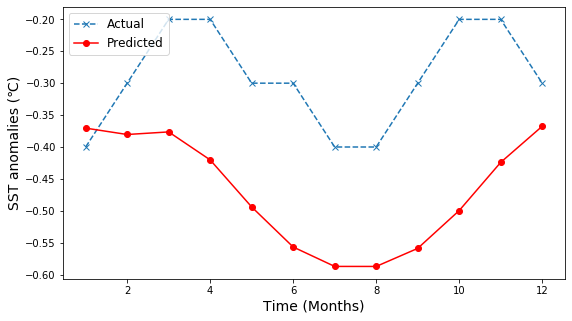

In [11]:
import os
print (round_true_values)
print (predicted_values)

if(os.path.exists('12_months_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_ConvLSTM_Encoder-Decoder Model_EMD')

plt.figure(figsize=(9,5))
index_start = np.array(range(1,13))
#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
plt.plot(index_start,round_true_values.reshape(-1),marker="x",linestyle='--',label='Actual')
plt.plot(index_start,predicted_values.reshape(-1),color="red",marker="o",label='Predicted')

plt.xlabel('Time (Months)',fontsize=14,color="black")
plt.ylabel('SST anomalies (℃)',fontsize=14,color="black")

plt.legend(loc=2,fontsize=12) 

plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_the_final_predicting_and_real_result.png')
plt.show() 
